## **Business Understanding**

Predicting sales is crucial for business planning. In this project, we'll use machine learning to build a model that forecasts store sales. We'll use data from Corporation Favorita, a leading grocery retailer in Ecuador.

### **Project Objective** 

Our main goal is to create a Machine Learning Model that predicts unit sales for various items sold in Favorita stores.

We'll analyze sales trends over time to understand customer behavior, identify seasonal patterns, and recognize other factors affecting sales. Factors like oil prices, holidays, and promotions can impact sales at Favorita. By analyzing this data, we aim to provide valuable insights to grocery retailers about customer preferences and behavior.

Further, by examining data on customer purchases, demographics, and social media activity, retailers can better understand what drives their customers. This information can help tailor marketing strategies to boost sales. Additionally, it can help identify slow-selling products, optimize inventory, reduce costs, and increase profits—especially for perishable items like dairy and meat.

We'll also look into improving checkout processes to enhance the shopping experience.

In summary, accurate sales forecasting helps businesses plan better, manage inventory efficiently, and make informed decisions. This precision enables companies like Favorita to reduce costs and increase profitability.

### **Project Approach and Methodology**

This project will adhere to the CRISP-DM (Cross-Industry Standard Process for Data Mining) Framework, a widely recognized methodology for data science projects. We will explore various machine learning techniques to achieve accurate sales predictions, including but not limited to:

1. **Time Series Forecasting**

Employing ARIMA, SARIMA, or LSTM to detect sales trends and seasonal variations.

2. **Regression Models**

Utilizing linear regression, decision trees, random forests, or gradient boosting to evaluate factors such as promotions, product attributes, and store specifics.

### **Hypothesis Testing**
H0(Null Hypothesis) - Promotion Activities have no significant effect on sales

H1(Alternative Hypothesis) - Promotion activities have a significant effect on sales

### **Analytical Questions**

1. Is the train dataset complete (has all the required dates)?
2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?
3. Compare the sales for each month across the years and determine which month of which year had the highest sales.
4. Did the earthquake impact sales?
5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)
6. Are sales affected by promotions, oil prices and holidays?
7. What analysis can we get from the date and its extractable features?
8. Which product family and stores did the promotions affect.
9. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)
10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.

## **Data Understanding**

#### **Importations**

In [3]:
# Environment Setup
import dotenv
from dotenv import dotenv_values

# Data Handling
import pyodbc
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Statistical Analysis
import scipy
import scipy.stats as stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error, r2_score
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Machine Learning
from pmdarima import auto_arima
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from scipy.stats import uniform, randint
from sklearn.metrics import make_scorer

# Utility and Miscellaneous
import warnings
warnings.filterwarnings("ignore")
import zipfile
import os
import requests 
import joblib

In [4]:
# Load .env values
environment_variables = dotenv_values(r"C:\Users\Admin\OneDrive\OneDrive-Azubi\Time_Serries_Corp.Favourita\Time-Series-Regression-Analysis-Corporation-Favorita-\.env")

# Get .env values
server =  environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

# Create a connection string
connection_string=f"DRIVER={{SQL Server}};SERVER={server};DATABASE={database};UID={username};PWD={password}"

In [5]:
# Connect to the database
connection = pyodbc.connect(connection_string)

 **Oil_data**

In [6]:
# Get data from table dbo.oil in the database
query_dbo_oil = "SELECT * FROM dbo.oil"
oil_data = pd.read_sql(query_dbo_oil, connection)
oil_data.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997



-Daily oil price which includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and changes in prices affects the economy of the country with a ripple effect on sales such as corporate favorita)

-The term "dcoilwtico" refers to the daily crude oil price for West Texas Intermediate (WTI) crude oil

In [7]:
# Describe the oil data numerical values
oil_data.describe()

,dcoilwtico
count,1175.000000
mean,67.714366
std,25.630476
min,26.190001
25%,46.405001
50%,53.189999
75%,95.660000
max,110.620003


In [8]:
# Describe oil data categorical values
oil_data.describe(include='object')

,date
count,1218
unique,1218
top,2013-01-01
freq,1


In [9]:
# Check for null values in the oil data 
print(f"Oil data null values: \n{oil_data.isnull().sum()}")

Oil data null values: 
date           0
dcoilwtico    43
dtype: int64


In [10]:
# Check for duplicates in the oil data
print(f"Oil data duplicates: \n{oil_data.duplicated().sum()}")

Oil data duplicates: 
0


In [11]:
# Check information for oil data
oil_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [12]:
# copying oil data for plotting
oil_data_cp=oil_data.copy()

oil_data_cp
# Converting 'date' to datetime format
oil_data_cp['date'] = pd.to_datetime(oil_data_cp['date'])
# Settting 'date' as the index
oil_data_cp.set_index('date', inplace=True)

# Grouping the data by year and summing the 'dcoilwtico' values
grouped_data = oil_data_cp.resample('Y')['dcoilwtico'].mean()

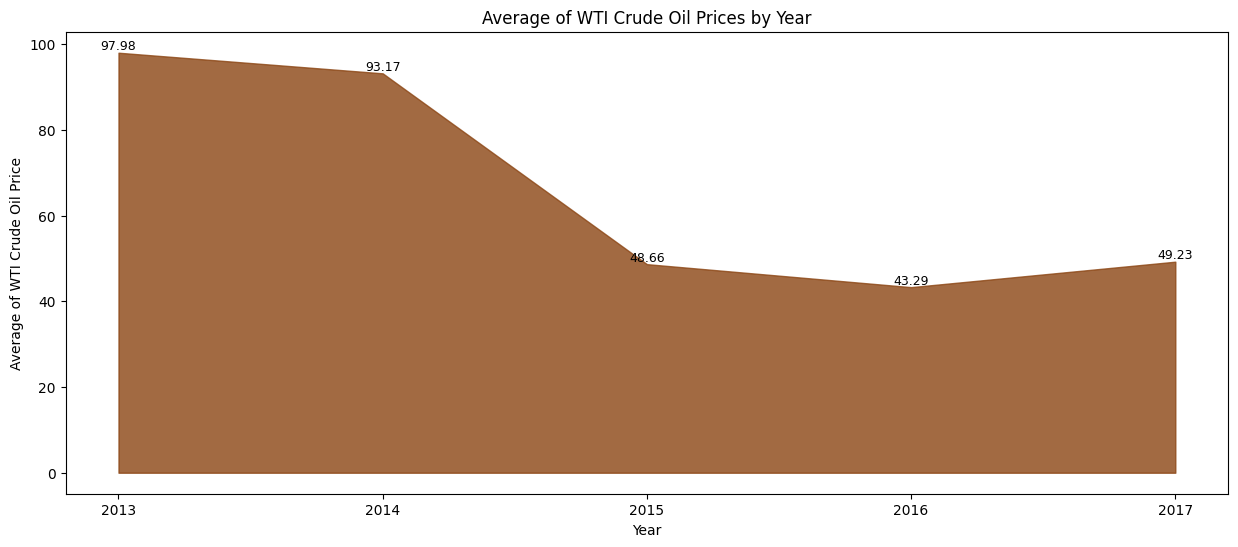

In [13]:
# Plotting area chart 
plt.figure(figsize=(15, 6))
plt.fill_between(grouped_data.index.year, grouped_data.values, color='#8B4513', alpha=0.8)

# Adding data labels
for i, value in enumerate(grouped_data.values):
    plt.text(grouped_data.index.year[i], value, str(round(value, 2)), ha='center', va='bottom', fontsize=9)

plt.xticks(grouped_data.index.year)
plt.xlabel('Year')
plt.ylabel('Average of WTI Crude Oil Price')
plt.title('Average of WTI Crude Oil Prices by Year')
plt.show()

- Key Insights- oil data

-There are 43 missing values in oild data. Partcularaly the dcoilwtico column

-The date column is an object insted of datetime

**Holidays_events_data**

-Holidays and Events, with metadata NB: Take a keen look at the transferred column. A holiday that is transferred officially falls on that calendar day but was moved to another date by the government. 

-A transferred day is more like a normal day than a holiday. To find the day that it was celebrated, look for the corresponding row where type is Transfer.

For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.

-Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

In [14]:
# Load data from dbo.holidays_events table in the database
query_dbo_holidays_events = "SELECT * FROM dbo.holidays_events"
holidays_events_data = pd.read_sql(query_dbo_holidays_events, connection)
holidays_events_data.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [15]:
# Get info of the holiday events database
holidays_events_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [16]:
# Check for null values in the holiday events data
holidays_events_data.isnull().sum()

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64

In [17]:
# Check for duplicates in the holiday events data
holidays_events_data.duplicated().sum()

0

In [18]:
# Unique holiday events
holidays_events_data['locale'].unique()

array(['Local', 'Regional', 'National'], dtype=object)

In [19]:
# Unique holiday types
holidays_events_data['type'].unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

In [20]:
# Unique locale names
holidays_events_data['locale_name'].unique()

array(['Manta', 'Cotopaxi', 'Cuenca', 'Libertad', 'Riobamba', 'Puyo',
       'Guaranda', 'Imbabura', 'Latacunga', 'Machala', 'Santo Domingo',
       'El Carmen', 'Cayambe', 'Esmeraldas', 'Ecuador', 'Ambato',
       'Ibarra', 'Quevedo', 'Santo Domingo de los Tsachilas',
       'Santa Elena', 'Quito', 'Loja', 'Salinas', 'Guayaquil'],
      dtype=object)

- Key insights- Holidays_events

-The date column is an object instead of datetime

-Change tranfered column from bool to object/category

-There are no null values

-There are no duplicates

**Stores_data**

In [21]:
# Load data from dbo.stores table in the database
query_dbo_stores = "SELECT * FROM dbo.stores"
stores_data = pd.read_sql(query_dbo_stores, connection)
stores_data.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [22]:
# Get info of the stores dataset
stores_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [23]:
# Get all unique store numbers
stores_data['store_nbr'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54], dtype=int64)

In [24]:
# Get all unique cities 
stores_data['city'].unique()

array(['Quito', 'Santo Domingo', 'Cayambe', 'Latacunga', 'Riobamba',
       'Ibarra', 'Guaranda', 'Puyo', 'Ambato', 'Guayaquil', 'Salinas',
       'Daule', 'Babahoyo', 'Quevedo', 'Playas', 'Libertad', 'Cuenca',
       'Loja', 'Machala', 'Esmeraldas', 'Manta', 'El Carmen'],
      dtype=object)

In [25]:
# Get all unique clusters
stores_data['cluster'].unique()

array([13,  8,  9,  4,  6, 15,  7,  3, 12, 16,  1, 10,  2,  5, 11, 14, 17],
      dtype=int64)

In [26]:
# Get all unique type of stores
stores_data['type'].unique()

array(['D', 'B', 'C', 'E', 'A'], dtype=object)

In [27]:
# Check for duplicates
stores_data.duplicated().sum()

0

In [28]:
# Check for null values
stores_data.isna().sum()   

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

- Key Insights - stores_data

-Store data includes: store_nbr -identifies the store at which the products are sold, city, state, type, and cluster.

-cluster is a grouping of similar stores

-There are no missing values 

-There are no duplicated values 


**Datasets from Github repository zip file- still part of train dataset in modeling and evaluation in this project**

In [29]:
# URL of the file to download
url = "https://github.com/Njuraita/Career_Accelerator_LP3-Regression/raw/main/store-sales-forecasting.zip"
 
# Local file path where the file will be saved
local_file_path = '../data/store-sales-forecasting.zip'
 
# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(local_file_path), exist_ok=True)
 
# Send a GET request to the URL
response = requests.get(url)
 
# Check if the request was successful (status code 200)
if response.status_code == 200:
    # Write the content of the response to the specified file path
    with open(local_file_path, "wb") as f:
        f.write(response.content)
    print("File downloaded successfully")
   
    # Extract the ZIP file
    with zipfile.ZipFile(local_file_path, 'r') as zip_ref:
        zip_ref.extractall(os.path.dirname(local_file_path))
    print("File extracted successfully")
else:
    print(f"Failed to download file. Status code: {response.status_code}")

File downloaded successfully
File extracted successfully


**df_train (train.csv)**

In [30]:
# Read the downloaded CSV file into a DataFrame
df_train = pd.read_csv('../data/train.csv')
 
# Display the DataFrame
df_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [31]:
# Check for nulls in train_data
df_train.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [32]:
# Check for duplicates in train_data
df_train.duplicated().sum()

0

In [33]:
# Describe the categoricainclus columns in train data
df_train.describe(include='object')

,date,family
count,3000888,3000888
unique,1684,33
top,2013-01-01,AUTOMOTIVE
freq,1782,90936


In [34]:

# Describe the numerical columns in train data
df_train.drop(['id', 'store_nbr'], axis=1).describe()

,sales,onpromotion
count,3.000888e+06,3.000888e+06
mean,3.577757e+02,2.602770e+00
std,1.101998e+03,1.221888e+01
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,1.100000e+01,0.000000e+00
75%,1.958473e+02,0.000000e+00
max,1.247170e+05,7.410000e+02


In [35]:
# Get information about the data
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [36]:
# Get unique family names
df_train['family'].unique()

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

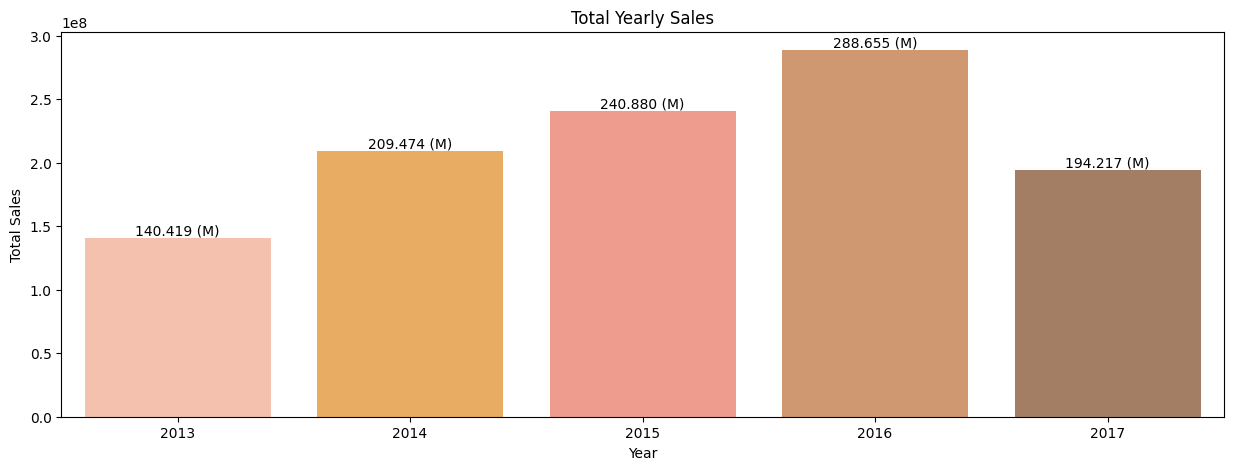

In [37]:
# Copy the train data
df_train_cp = df_train.copy()

# Convert 'date' column to datetime type
df_train_cp['date'] = pd.to_datetime(df_train_cp['date'])

# Extracting year from the 'date' column and setting it as index
df_train_cp.set_index(df_train_cp['date'].dt.year, inplace=True)
df_train_cp.index.name = 'year'  # Naming the index as 'year'

# Grouping by year and summing the sales
total_yearly_sales = df_train_cp.groupby('year')['sales'].sum()

# Plotting the total yearly sales with a bar plot
custom_palette = ['#FFA07A', '#FF8C00', '#FF6347', '#D2691E', '#8B4513']
plt.figure(figsize=(15, 5))
barplot = sns.barplot(x=total_yearly_sales.index, y=total_yearly_sales.values, palette=custom_palette, alpha=0.7)
for index, value in enumerate(total_yearly_sales):
    label = f'{value / 1e6:.3f} (M)'  # Format value in Millions
    barplot.text(index, value, label, ha='center', va='bottom')
plt.xlabel('Year')
plt.ylabel('Total Sales')
plt.title('Total Yearly Sales')
plt.show()


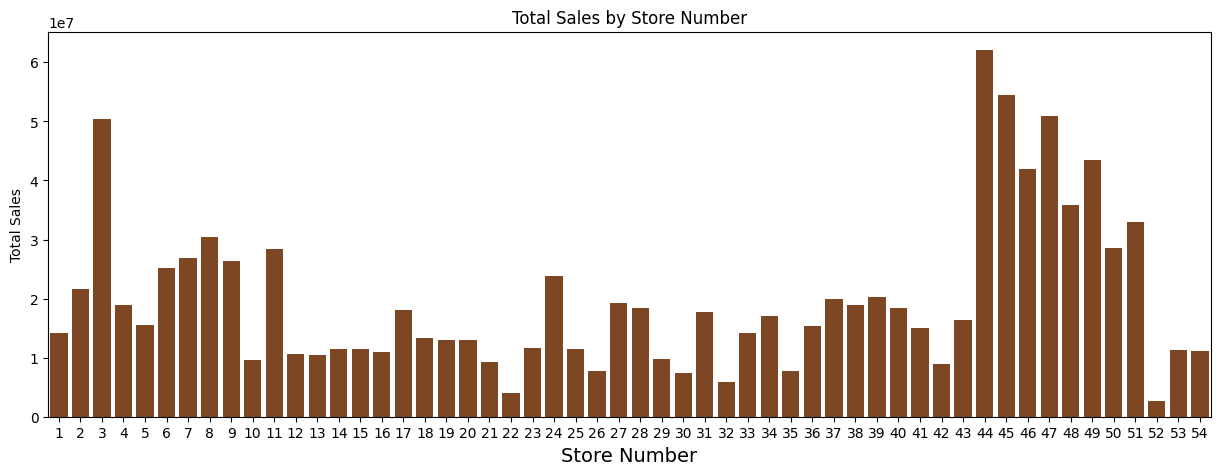

In [38]:
# Grouping by year and summing the sales
total_yearly_sales = df_train_cp.groupby('store_nbr')['sales'].sum()

# Plotting the total yearly sales with a bar plot
plt.figure(figsize=(15,5))
barplot = sns.barplot(x=total_yearly_sales.index, y=total_yearly_sales.values, color='#8B4513', alpha=1)
plt.xlabel('Store Number', fontsize=14)
plt.ylabel('Total Sales')
plt.title('Total Sales by Store Number')
plt.show()

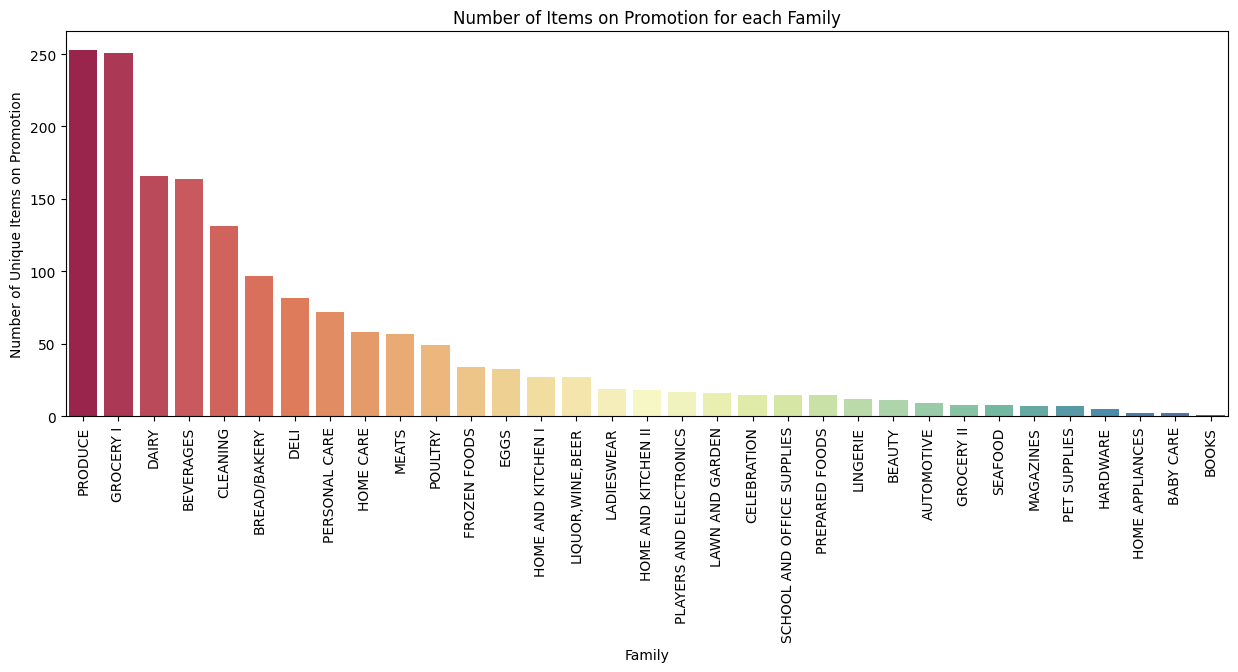

In [39]:
# Plot number of unique items on promotion for each family
plt.figure(figsize=(15,5))
train_data_cp_promotion = df_train_cp.groupby('family')['onpromotion'].nunique().sort_values(ascending=False)
ax = sns.barplot(train_data_cp_promotion, palette='Spectral')
plt.title('Number of Items on Promotion for each Family')
plt.xlabel('Family')
plt.ylabel('Number of Unique Items on Promotion')
plt.xticks(rotation=90)
plt.show()

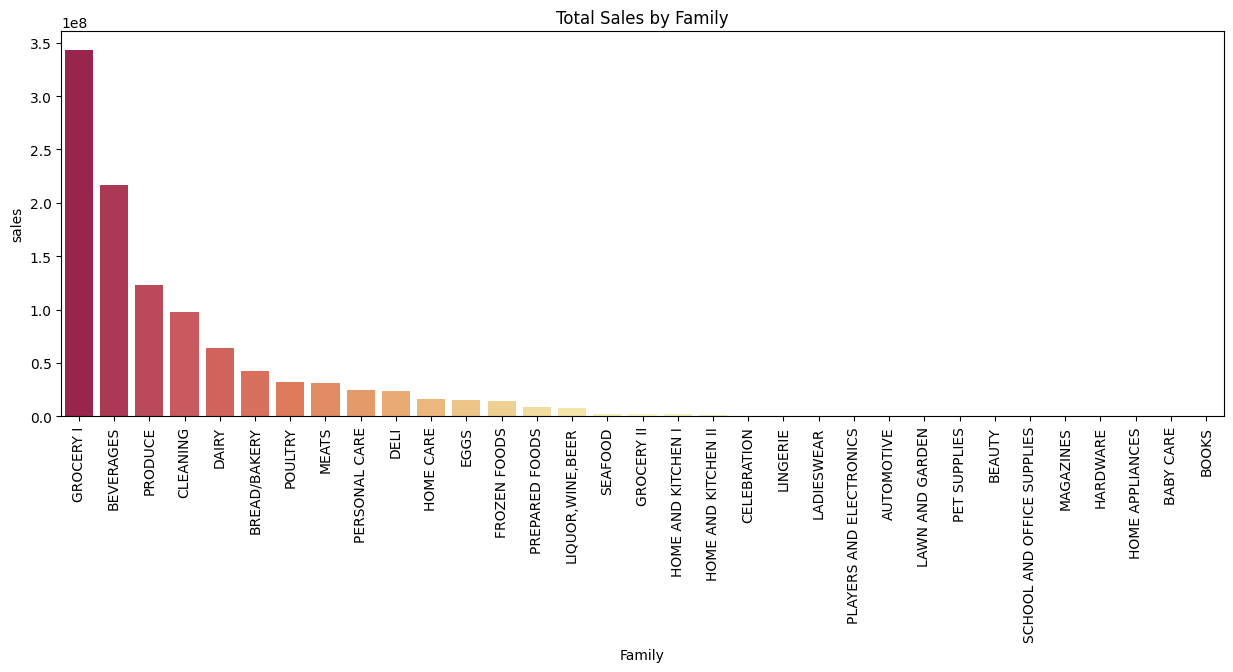

In [40]:
# Plot plot total saled for each family
plt.figure(figsize=(15,5))
train_data_cp_promotion = (df_train_cp.groupby('family')['sales'].sum()).sort_values(ascending=False)
ax = sns.barplot(train_data_cp_promotion, palette='Spectral')
plt.title('Total Sales by Family')
plt.xlabel('Family')
plt.xticks(rotation=90)
plt.show()

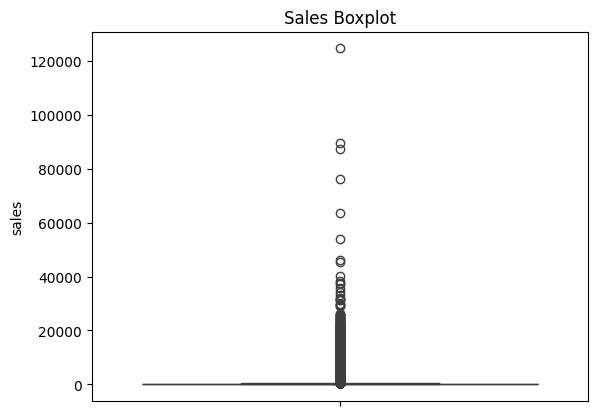

In [41]:
# Sales boxplot
sns.boxplot(df_train_cp['sales'])
plt.title('Sales Boxplot')
plt.show()

<Axes: ylabel='onpromotion'>

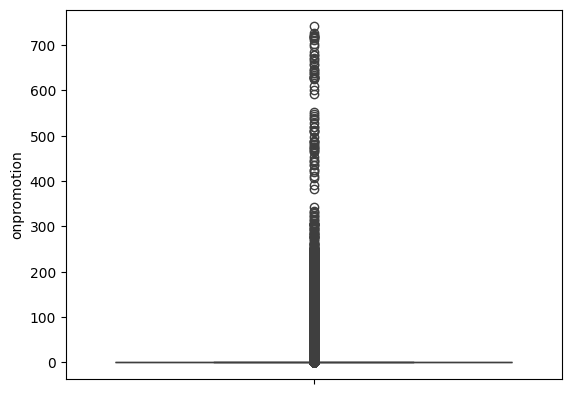

In [42]:
# Onpromotion boxplot
sns.boxplot(df_train_cp['onpromotion'])

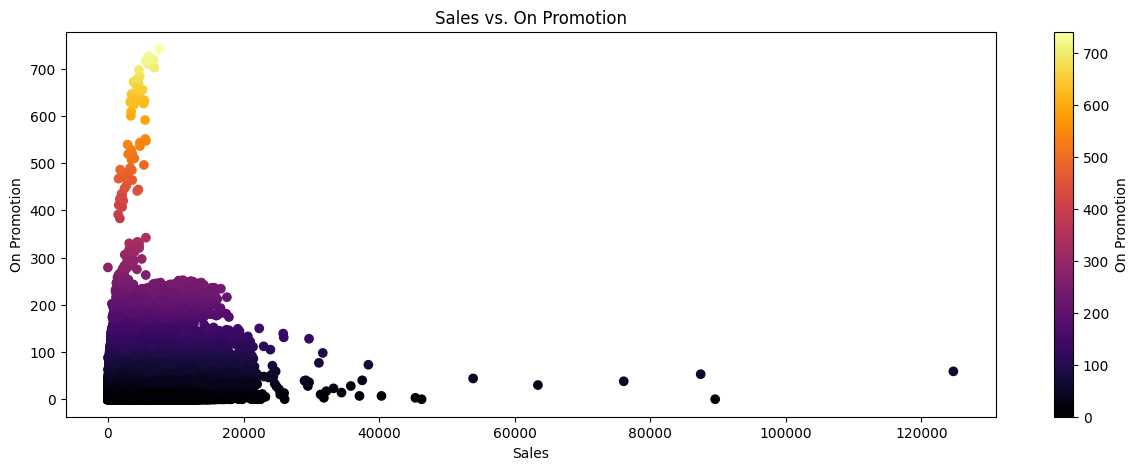

In [43]:
# Extracting sales and onpromotion data
sales = df_train_cp['sales']
on_promotion = df_train_cp['onpromotion']

# Plotting scatter plot with different colors for onpromotion
plt.figure(figsize=(15, 5))
plt.scatter(sales, on_promotion, c=on_promotion, cmap='inferno')
plt.xlabel('Sales')
plt.ylabel('On Promotion')
plt.title('Sales vs. On Promotion')
plt.colorbar(label='On Promotion')
plt.show()

- The train_csv (df_train), comprising time series of features store_nbr, family, and onpromotion as well as the target sales.

-store_nbr identifies the store at which the products are sold.

-family identifies the type of product sold.

-sales gives the total sales for a product family at a particular store at a given date. Fractional values are possible since products can be sold in fractional units (1.5 kg of butter, for instance, as opposed to 1 box of soap).

-onpromotion gives the total number of items in a product family that were being promoted at a store at a given date.

**df_transaction (transactions_csv)**

In [44]:
# Read the downloaded CSV file into a DataFrame
df_transactions = pd.read_csv('../data/transactions.csv')
 
# Display the DataFrame
df_transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [45]:
# Check for nulls
df_transactions.isna().sum()

date            0
store_nbr       0
transactions    0
dtype: int64

In [46]:
# Check for duplicates
df_transactions.duplicated().sum()

0

In [47]:
# Describe data
df_transactions.describe().T

,count,mean,std,min,25%,50%,75%,max
store_nbr,83488.0,26.939237,15.608204,1.0,13.0,27.0,40.0,54.0
transactions,83488.0,1694.602158,963.286644,5.0,1046.0,1393.0,2079.0,8359.0


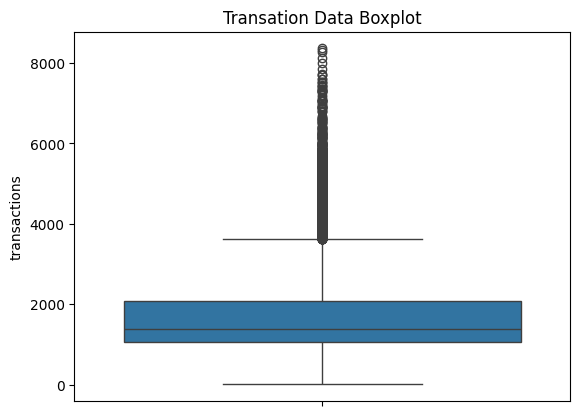

In [48]:
# Boxplot to show distribution of transactions
sns.boxplot(df_transactions['transactions'])
plt.title('Transation Data Boxplot')
plt.show()

- Key insights

-There are some outliers in the transaction column

-There are no nulss or duplicates in the dataset

#### **Decomposition**

- In time series analysis, data is typically composed of four components: level (average value), trend (increasing or decreasing pattern), seasonality (repeating cycles), and noise (random variation). These can be combined in either an additive or multiplicative model
- **Additive Model**: The components are summed.
𝑦(𝑡)=Level+Trend+Seasonality+Noise
y(t)=Level+Trend+Seasonality+Noise
This linear model assumes consistent changes over time

- **Multiplicative Model**: The components are multiplied.
- 𝑦(𝑡)=Level×Trend×Seasonality×Noise
y(t)=Level×Trend×Seasonality×Noise
This nonlinear model allows for changing patterns over time

- Decomposition helps in structuring time series data for analysis, addressing each component during data preparation and modeling. The seasonal_decompose() method in the statsmodels library can be used to implement this, specifying whether the model is additive or multiplicative

**Components:**
- Seasonal Component: Represents repeating patterns or fluctuations at regular intervals (e.g., seasons, holidays). Values are constant for each corresponding period across multiple years

- Trend Component: Captures the long-term direction (increase or decrease) in the data. Represented by a function (linear or nonlinear) reflecting the overall trend

- Residual Component: Represents the unexplained part of the data after accounting for the seasonal and trend components. These residuals are typically random and normally distributed

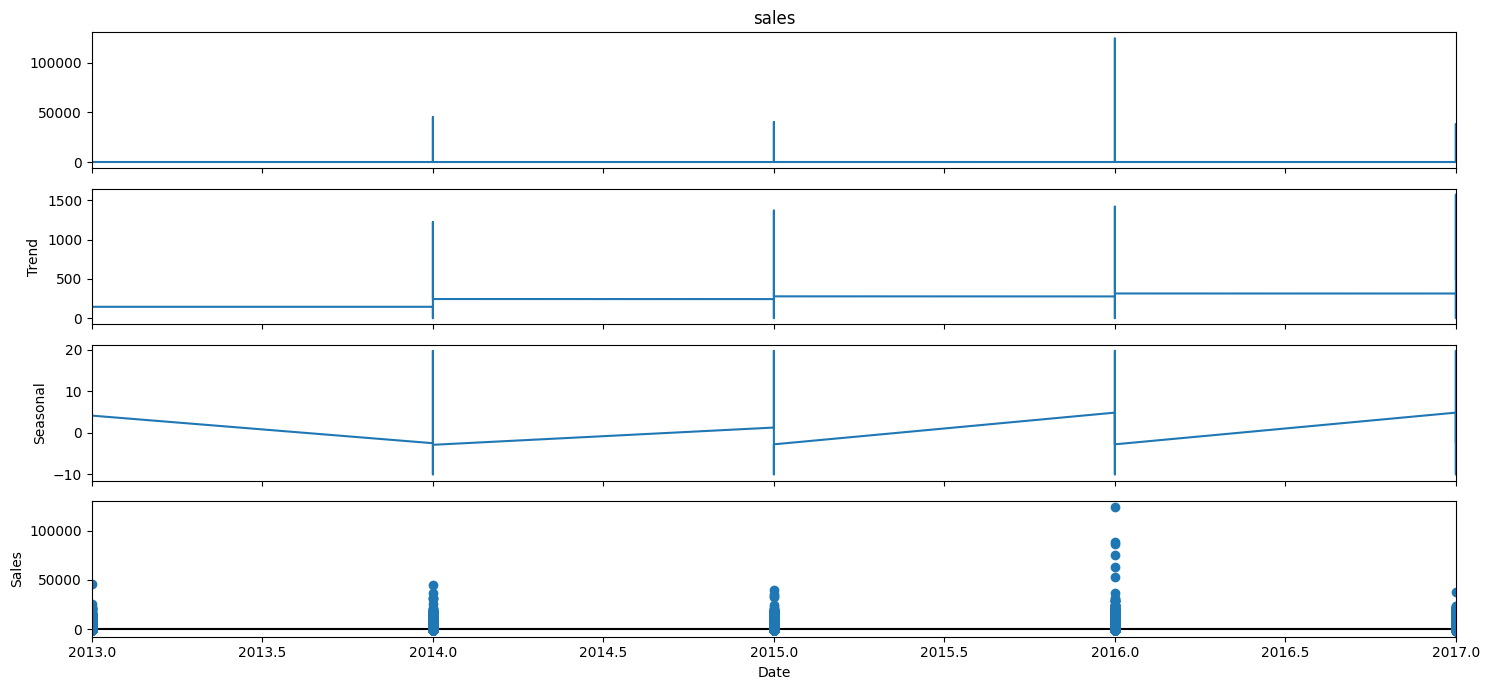

In [49]:
# Decompose to show trend, seasonal, and residual of sales over time
result_add = seasonal_decompose(df_train_cp['sales'], model='additive', period=365)  # daily frequency
plt.rcParams.update({'figure.figsize': (15, 7)})  # Adjusting figure size
result_add.plot()
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout() 
plt.show()

- Key Insights

-There is an upward trend of sales

-There is no seasonality in sales

-Mostly residuals are at the beginning of every year

**Check for Stationality**

-Null Hypothesis = Series is stationary

-Alternate Hypothesis = Series is non-stationary

In [50]:
# Perform KPSS test
kpss_stats, kpss_p, _, kpss_critical_values = kpss(df_train_cp['sales'])
# Print KPSS test results
print('KPSS Test Results:')
print(f'Test Statistic: {kpss_stats}')
print(f'p-value: {kpss_p}')
print('Critical Values:')
for key, value in kpss_critical_values.items():
    print(f'\t{key}: {value}')
if kpss_p < 0.05:
    print('Series is not stationary according to KPSS test')
else:
    print('Series is stationary according to KPSS test')

KPSS Test Results:
Test Statistic: 147.40710312148062
p-value: 0.01
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739
Series is not stationary according to KPSS test


**Hypothesis Testing**

H0 (Null Hypothesis) - Promotion Activities have no significant effect on sales
Ha (Alternative Hypothesis) - Promotion activities have a significant effect on sales

In [51]:
# Split Promoted items and those that were not promoted

df_train_cp['onpromotion_encoded'] = np.where(df_train_cp['onpromotion'] >= 1, 1, 0)
df_train_cp['onpromotion_encoded'].value_counts()

onpromotion_encoded
0    2389559
1     611329
Name: count, dtype: int64

In [52]:
# Get sales data for items on promotion and not on promotion
sales_on_promotion = df_train_cp[df_train_cp['onpromotion_encoded'] == 1]['sales']
sales_not_on_promotion = df_train_cp[df_train_cp['onpromotion_encoded'] == 0]['sales']

# Calculate means of sales
mean_sales_on_promotion = sales_on_promotion.mean()
mean_sales_not_on_promotion = sales_not_on_promotion.mean()

print(f"Mean of sales on promotion: {mean_sales_on_promotion}")
print(f"Mean of sales not on promotion: {mean_sales_not_on_promotion}")

# Calculate the critical t-values for a two-tailed test
alpha = 0.05
n_on_promotion = len(sales_on_promotion)
n_not_on_promotion = len(sales_not_on_promotion)
df = n_on_promotion + n_not_on_promotion - 2  # degree of freedom
t_critical_left = stats.t.ppf(alpha / 2, df)  # left critical value
t_critical_right = stats.t.ppf(1 - alpha / 2, df)  # right critical value

print(f"Left Critical t-value: {t_critical_left}")
print(f"Right Critical t-value: {t_critical_right}")
print(f"Degrees of Freedom: {df}")

# Calculate the t-statistic
pooled_var = ((n_on_promotion - 1) * sales_on_promotion.var() + (n_not_on_promotion - 1) * sales_not_on_promotion.var()) / df
t_stat = (mean_sales_on_promotion - mean_sales_not_on_promotion) / np.sqrt(pooled_var * (1 / n_on_promotion + 1 / n_not_on_promotion))

print(f"t-statistic: {t_stat}")

# Calculate the p-value
p_value = stats.t.sf(np.abs(t_stat), df) * 2

print(f"p-value: {p_value}")

# Interpret the results
if p_value < alpha:
    print("We reject the null hypothesis")
    print("Promotion activities have a significant effect on sales")
else:
    print("We fail to reject the null hypothesis")
    print("Promotion activities have no significant effect on sales")


Mean of sales on promotion: 1137.6937303133943
Mean of sales not on promotion: 158.2466813936427
Left Critical t-value: -1.9599647750639766
Right Critical t-value: 1.9599647750639762
Degrees of Freedom: 3000886
t-statistic: 664.1236909096903
p-value: 0.0
We reject the null hypothesis
Promotion activities have a significant effect on sales


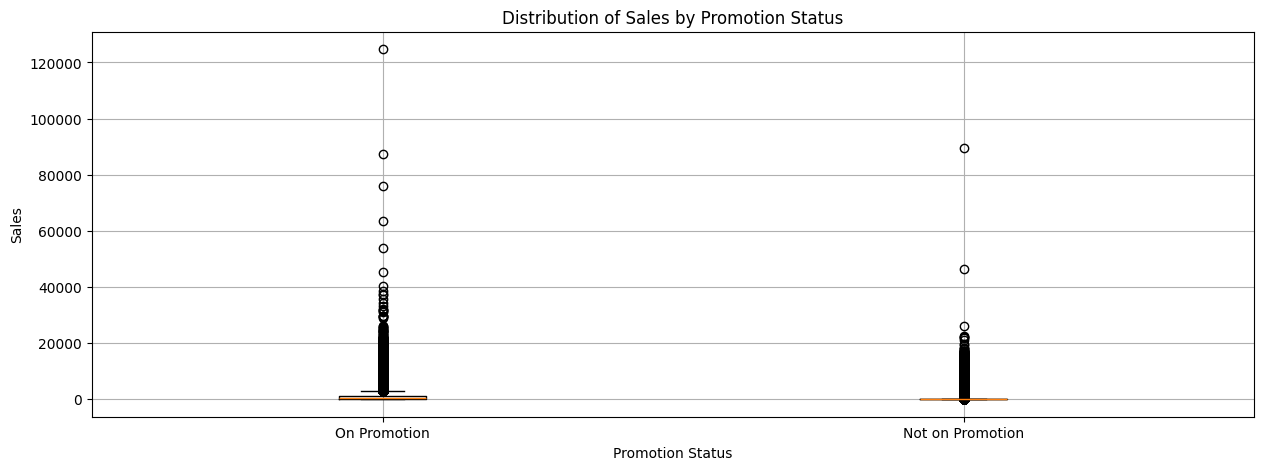

In [53]:
# Create a box plot for sales on promotion and sales not on promotion
plt.figure(figsize=(15, 5))
plt.boxplot([sales_on_promotion, sales_not_on_promotion], labels=['On Promotion', 'Not on Promotion'])
plt.title('Distribution of Sales by Promotion Status')
plt.ylabel('Sales')
plt.xlabel('Promotion Status')
plt.grid(True)
plt.show()

In [54]:
df_train_cp

,id,date,store_nbr,family,sales,onpromotion,onpromotion_encoded
year,,,,,,,
2013,0,2013-01-01,1,AUTOMOTIVE,0.000,0,0
2013,1,2013-01-01,1,BABY CARE,0.000,0,0
2013,2,2013-01-01,1,BEAUTY,0.000,0,0
2013,3,2013-01-01,1,BEVERAGES,0.000,0,0
2013,4,2013-01-01,1,BOOKS,0.000,0,0
...,...,...,...,...,...,...,...
2017,3000883,2017-08-15,9,POULTRY,438.133,0,0
2017,3000884,2017-08-15,9,PREPARED FOODS,154.553,1,1
2017,3000885,2017-08-15,9,PRODUCE,2419.729,148,1


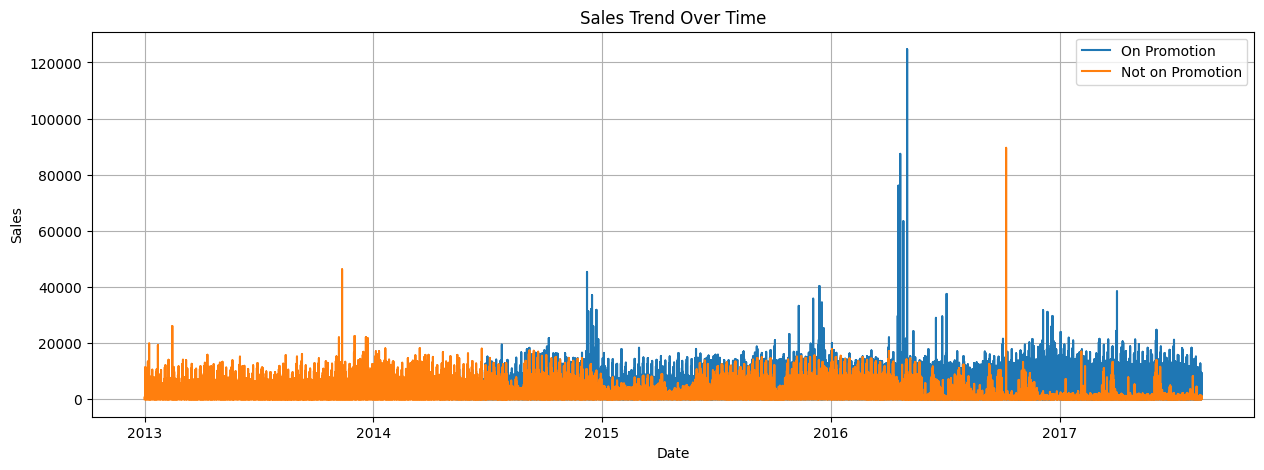

In [55]:
# Plot sales trend over time for items on promotion and items not on promotion
plt.figure(figsize=(15, 5))
plt.plot(df_train_cp[df_train_cp['onpromotion_encoded'] == 1]['date'], sales_on_promotion, label='On Promotion')
plt.plot(df_train_cp[df_train_cp['onpromotion_encoded'] == 0]['date'], sales_not_on_promotion, label='Not on Promotion')
plt.title('Sales Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

Notes
- It's clear that promotion activities have positive effects on sales
- There are more sales resulting from promotions as compared to to non-promotion activities

**Analytical Questions**

**1. Is the train dataset complete (has all the required dates)?**

In [56]:
# Check for null values in the train dataset
df_train.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

Dates Completion

In [57]:
# Get the minimum and the mazimum dates
df_train['date'].min(), df_train['date'].max()

('2013-01-01', '2017-08-15')

In [58]:
# save the min and max dates in variables
min_date =  df_train['date'].min()
max_date =  df_train['date'].max()

# Get the ecpected number of dates given the min and max dates
expected_dates = pd.date_range(start=min_date, end=max_date, freq='D')

# Get the actual number of dates
print(f"Expected number of unique dates: {len(expected_dates)},\nActual number of unique dates: {len( df_train['date'].unique())}")

Expected number of unique dates: 1688,
Actual number of unique dates: 1684


In [59]:
# Checking which dates are missing
dftrain_missing_dates = expected_dates.difference(df_train['date'].unique())
dftrain_missing_dates.to_list()

[Timestamp('2013-01-01 00:00:00'),
 Timestamp('2013-01-02 00:00:00'),
 Timestamp('2013-01-03 00:00:00'),
 Timestamp('2013-01-04 00:00:00'),
 Timestamp('2013-01-05 00:00:00'),
 Timestamp('2013-01-06 00:00:00'),
 Timestamp('2013-01-07 00:00:00'),
 Timestamp('2013-01-08 00:00:00'),
 Timestamp('2013-01-09 00:00:00'),
 Timestamp('2013-01-10 00:00:00'),
 Timestamp('2013-01-11 00:00:00'),
 Timestamp('2013-01-12 00:00:00'),
 Timestamp('2013-01-13 00:00:00'),
 Timestamp('2013-01-14 00:00:00'),
 Timestamp('2013-01-15 00:00:00'),
 Timestamp('2013-01-16 00:00:00'),
 Timestamp('2013-01-17 00:00:00'),
 Timestamp('2013-01-18 00:00:00'),
 Timestamp('2013-01-19 00:00:00'),
 Timestamp('2013-01-20 00:00:00'),
 Timestamp('2013-01-21 00:00:00'),
 Timestamp('2013-01-22 00:00:00'),
 Timestamp('2013-01-23 00:00:00'),
 Timestamp('2013-01-24 00:00:00'),
 Timestamp('2013-01-25 00:00:00'),
 Timestamp('2013-01-26 00:00:00'),
 Timestamp('2013-01-27 00:00:00'),
 Timestamp('2013-01-28 00:00:00'),
 Timestamp('2013-01-

Notes
- The minimum date is 2013-01-01, and the maximum date is 2017-08-15. After checking the range of dates between the minimum and maximum dates, we realize that the date column is not complete and is missing 4 dates.

- The missing dates are 2013-12-25, 2014-12-25, 2015-12-25, and 2016-12-25. After checking the missing dates, we realize that the 25th day of every December is missing, presumably because the day is Christmas, and most companies around the world are closed on Christmas.

**2. Which dates have the lowest and highest sales for each year (excluding days the store was closed)?**

Dates with the highest sales for each year
              date  year       sales
562596  2013-11-12  2013   46271.000
1257246 2014-12-08  2014   45361.000
1916586 2015-12-14  2015   40351.460
2163723 2016-05-02  2016  124717.000
2760297 2017-04-02  2017   38422.625


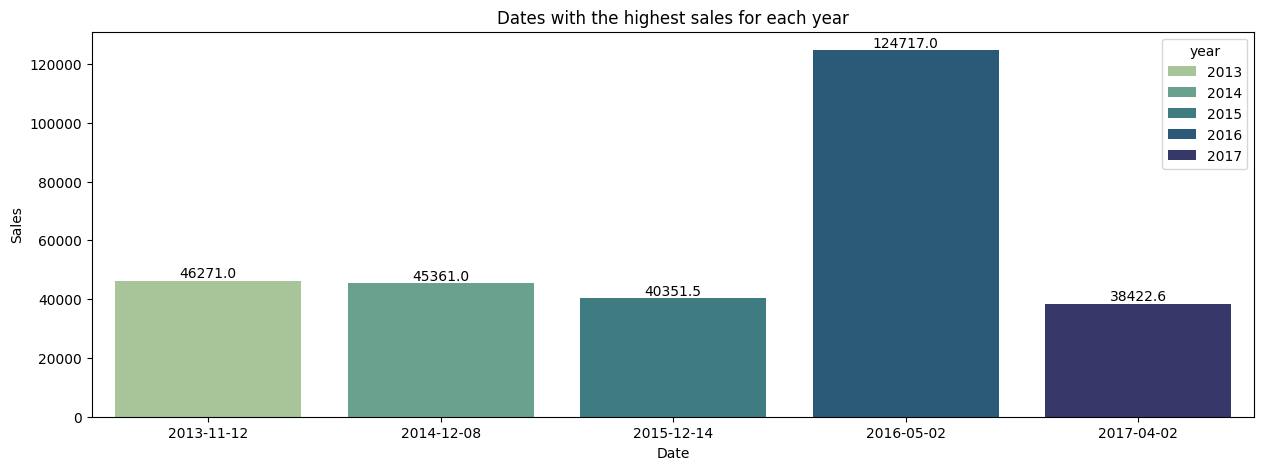

In [60]:
# Create a year column
df_train_cp['year'] = df_train_cp['date'].dt.year
df_train_cp.reset_index(drop=True, inplace=True)
max_sales= df_train_cp.groupby('year')['sales'].idxmax()
max_sales_rows = df_train_cp.loc[max_sales]

print("Dates with the highest sales for each year")

print(max_sales_rows[['date', 'year','sales']])

# visualize the hidgest sales data by date and year

plt.figure(figsize=(15,5))
sns.barplot(x=max_sales_rows['date'], y=max_sales_rows['sales'], hue=max_sales_rows['year'], palette='crest')
plt.xlabel('Date')
plt.ylabel('Sales')
for index, value in enumerate(max_sales_rows['sales']):
    label = f'{value:.1f}'
    plt.text(index, value, label, ha='center', va='bottom')
plt.title('Dates with the highest sales for each year')
plt.show()

In [61]:
# Filter out rows where sales are greater than 0
non_zero_sales_data = df_train_cp[df_train_cp['sales'] > 0]

# Get the index of the row with the minimum sales for each year
min_sales_idx = non_zero_sales_data.groupby('year')['sales'].idxmin()

# Retrieve the rows with the minimum sales for each year
min_sales_rows = non_zero_sales_data.loc[min_sales_idx]

print("Dates with the lowest sales for each year (excluding days with zero sales)")

print(min_sales_rows[['date', 'year', 'sales']])

Dates with the lowest sales for each year (excluding days with zero sales)
              date  year  sales
387782  2013-08-06  2013  0.122
1252052 2014-12-05  2014  0.188
1756358 2015-09-15  2015  0.196
2256638 2016-06-23  2016  0.396
2666498 2017-02-09  2017  0.426


Notes
- The first day of every year has the lowest sales for that year with zero sales being made.

**3. Compare the sales for each month across the years and determine which month of which year had the highest sales.**

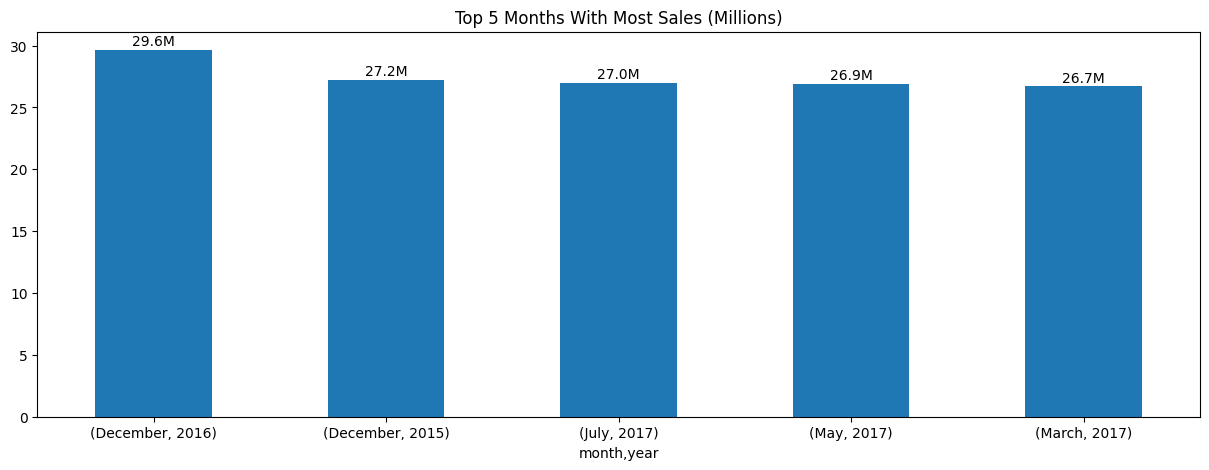

In [62]:
# Creating a column with the month names
df_train_cp['month'] = df_train_cp['date'].dt.month_name()

# Group sales by month and year
monthly_sales = df_train_cp.groupby(['month', 'year'])['sales'].sum().sort_values(ascending=False)

# Convert sales to millions
monthly_sales_millions = monthly_sales / 1000000

# Plotting the monthly sales
plt.figure(figsize=(15, 5))
ax = monthly_sales_millions.head(5).plot.bar()
plt.xticks(rotation=0)
plt.title('Top 5 Months With Most Sales (Millions)')
for i, v in enumerate(monthly_sales_millions.head(5)):
    plt.text(i, v + 0.1, f'{v:.1f}M', ha='center', va='bottom')
plt.show()

Notes
- December of 2016 was the month with the most sales
- The month had 29.6M sales followed closely by December of 2015 which had 27.2M worth of sales

**4. Did the earthquake impact sales?**

- A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

In [63]:
# Set the 'date' column as the index

df_train_cp.set_index('date', inplace=True)

In [64]:
# Resample to weekly frequency, aggregating with mean
total_weekly_sales = df_train_cp["sales"].resample('W').sum()

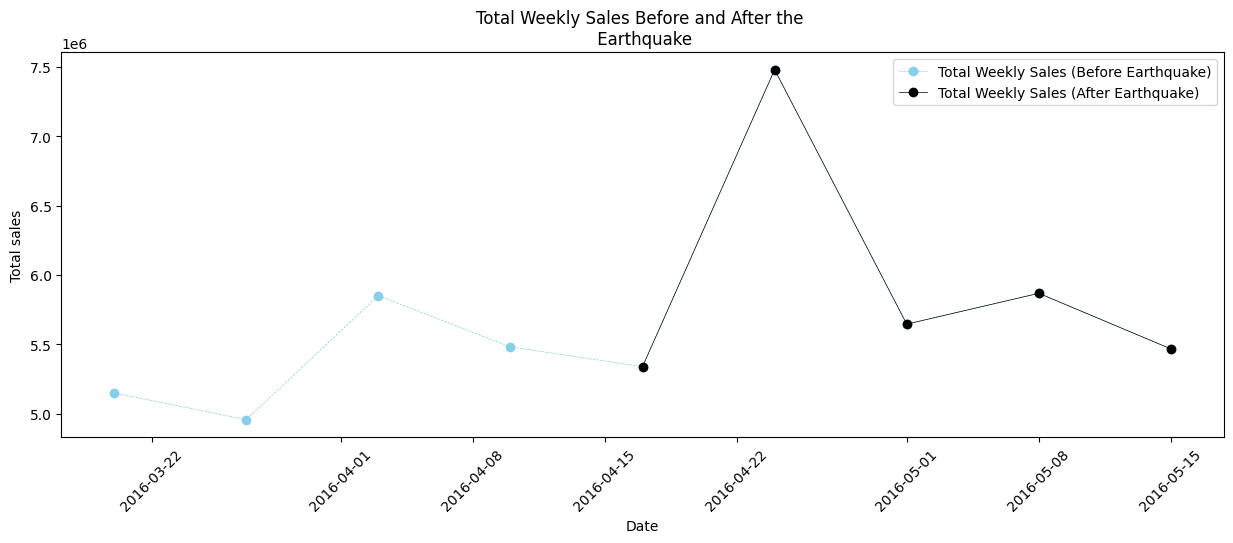

In [65]:
start = '2016-03-16'  # Date before the earthquake
after = '2016-04-16'  # Date of the earthquake
end = '2016-05-16'    # End date

# Slicing the data before and after the earthquake date
sales_before_w = total_weekly_sales.loc[start:end]
sales_after_w = total_weekly_sales.loc[after:end]

fig, ax = plt.subplots(figsize=(15, 5))

# Plotting the data before the earthquake date with one color
ax.plot(sales_before_w, marker='o', linestyle='--', linewidth=0.5, label='Total Weekly Sales (Before Earthquake)', color='skyblue')

# Plotting the data after the earthquake date with another color
ax.plot(sales_after_w, linestyle='-', marker='o', linewidth=0.5, label='Total Weekly Sales (After Earthquake)', color='black')

ax.set_ylabel("Total sales")
ax.set_xlabel("Date")
ax.tick_params(axis='x', labelrotation=45)
ax.legend()
ax.set_title("Total Weekly Sales Before and After the \n Earthquake")

plt.show()

Notes
- Following the earthquake, there was a notable surge in sales the day after the event.
- However, within a week, sales began to decline steadily, eventually returning to pre-earthquake levels.

**5. Are certain stores or groups of stores selling more products? (Cluster, city, state, type)**

In [66]:
# Merge train data with the stores data
str_train = df_train_cp.merge(stores_data, how='left', on='store_nbr')

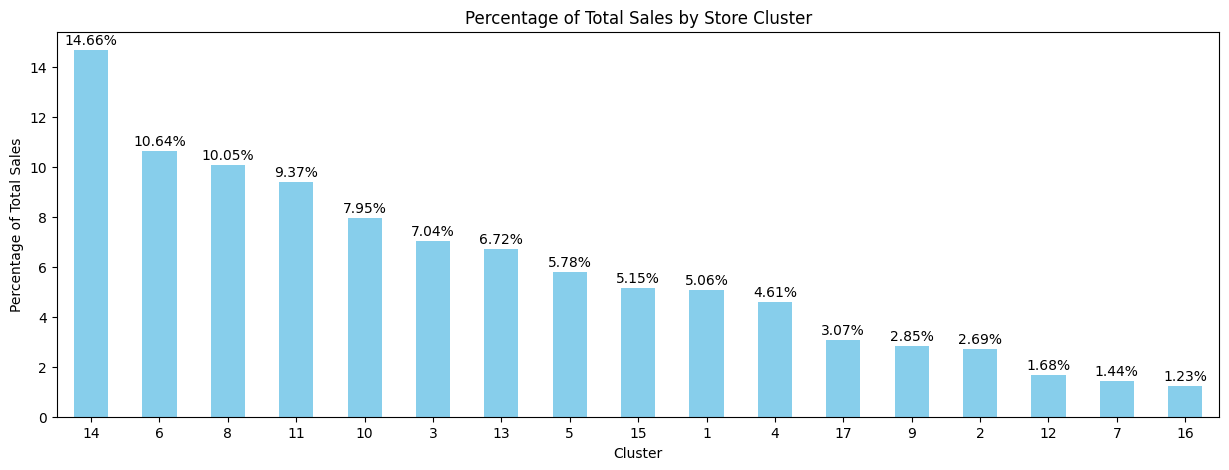

In [67]:
# Calculate total sales by cluster
cluster_sales = str_train.groupby('cluster')['sales'].sum().sort_values(ascending=False)

# Calculate overall total sales
overall_sales = str_train['sales'].sum()

# Calculate the percentage of each cluster's sales over the overall sales
percentage_sales = (cluster_sales / overall_sales) * 100

# Plot a barplot to visualize the percentage of sales by cluster
plt.figure(figsize=(15, 5))
percentage_sales_sorted = percentage_sales.sort_values(ascending=False)
percentage_sales_sorted.plot.bar(color='skyblue')

# Add labels to the bars
for i, percentage in enumerate(percentage_sales_sorted):
    plt.text(i, percentage + 0.1, f"{percentage:.2f}%", ha='center', va='bottom')

plt.title('Percentage of Total Sales by Store Cluster')
plt.xlabel('Cluster')
plt.ylabel('Percentage of Total Sales')
plt.xticks(rotation=0)
plt.show()

Notes
- There are 17 clusters
- Cluster 14, 6 and 8 are the best selling cluster with each of them contributing above 10% of the total sales
- Cluster 14% is the best selling cluster with 14.66 percent of the total sales, cluster 6 is second best selling cluster with 10.64% of the total sales and cluster 8 is third best selling cluster with 10.05% of the total sales.
- The three worst selling clusters are 12 7 and 16. Each of them contributes less than 2% of the total sales

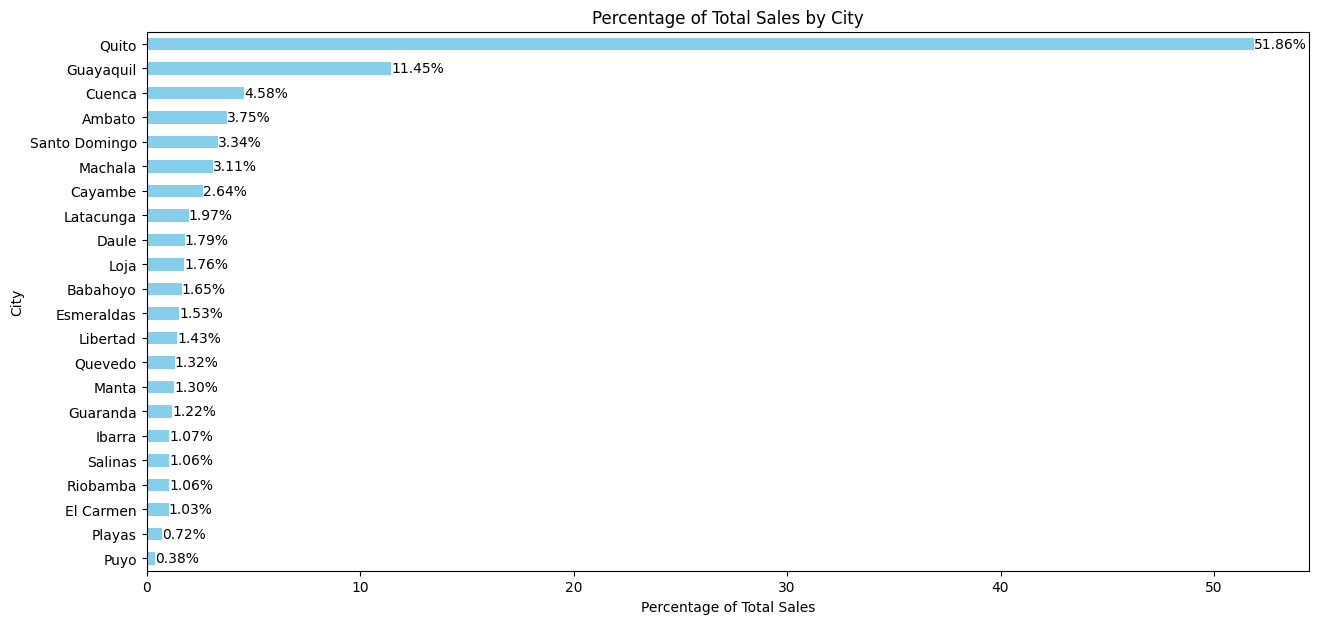

In [68]:
# Calculate total sales by city
city_sales = str_train.groupby('city')['sales'].sum().sort_values(ascending=False)

# Calculate the percentage of each city's sales over the overall sales
percentage_sales = (city_sales / overall_sales) * 100

# Plot a horizontal bar plot to visualize the percentage of sales by city
plt.figure(figsize=(15, 7))
percentage_sales_sorted = percentage_sales.sort_values(ascending=True)
percentage_sales_sorted.plot.barh(color='skyblue')

# Add labels to the bars
for index, value in enumerate(percentage_sales_sorted):
    plt.text(value, index, f'{value:.2f}%', ha='left', va='center')

plt.title('Percentage of Total Sales by City')
plt.xlabel('Percentage of Total Sales')
plt.ylabel('City')
plt.show()

Notes
- Quito is the best location with 51.86 percent sales of the total sales. it is the best location by far considering the second best location is at 11.45 percent
- The worst performing locations are Puyo City and Playas City with 0.38 and 0.72 percent sales

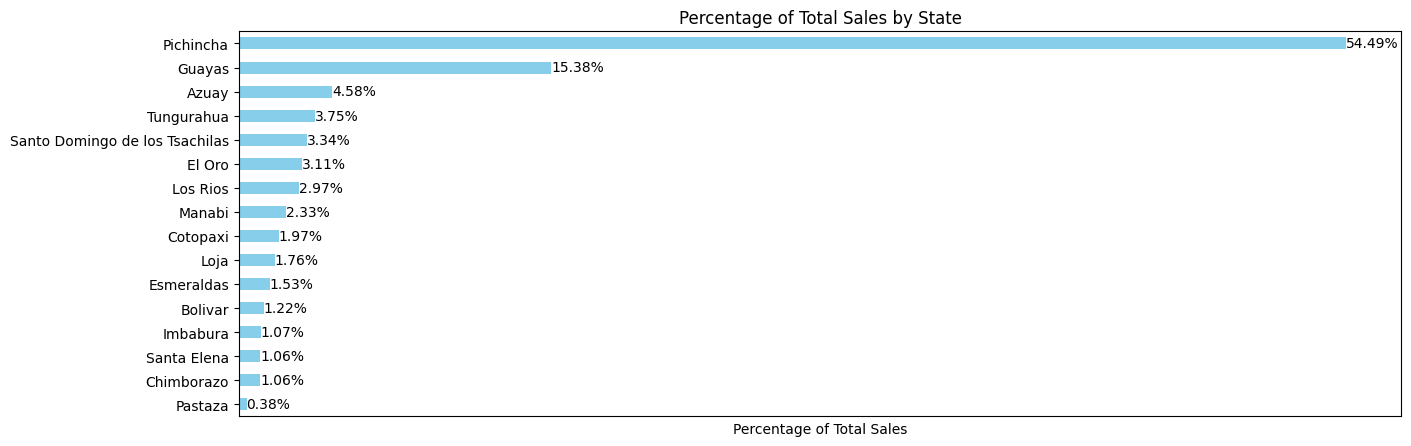

In [69]:
# Calculate total sales by state
state_sales = str_train.groupby('state')['sales'].sum().sort_values(ascending=False)

# Calculate overall total sales
overall_sales = str_train['sales'].sum()

# Calculate the percentage of each state's sales over the overall sales
percentage_sales = (state_sales / overall_sales) * 100

# Plot a horizontal bar plot to visualize the percentage of sales by state
plt.figure(figsize=(15, 5))
percentage_sales_sorted = percentage_sales.sort_values(ascending=True)
percentage_sales_sorted.plot.barh(color='skyblue')

# Add labels to the bars
for index, value in enumerate(percentage_sales_sorted):
    plt.text(value, index, f'{value:.2f}%', ha='left', va='center')

plt.title('Percentage of Total Sales by State')
plt.xlabel('Percentage of Total Sales')
plt.xticks([])
plt.ylabel('')
plt.show()

Notes
- Pichicha is by far the best performing state contributing 54.49% of the total sales. The second is Guayas at 15.38 percent of the total sales

- The worst performing state is Pastaza at 0.38% of the total sales

type
A    353,043,841.80
D    351,083,296.86
C    164,434,742.56
B    145,260,635.13
E     59,822,435.84
Name: sales, dtype: object


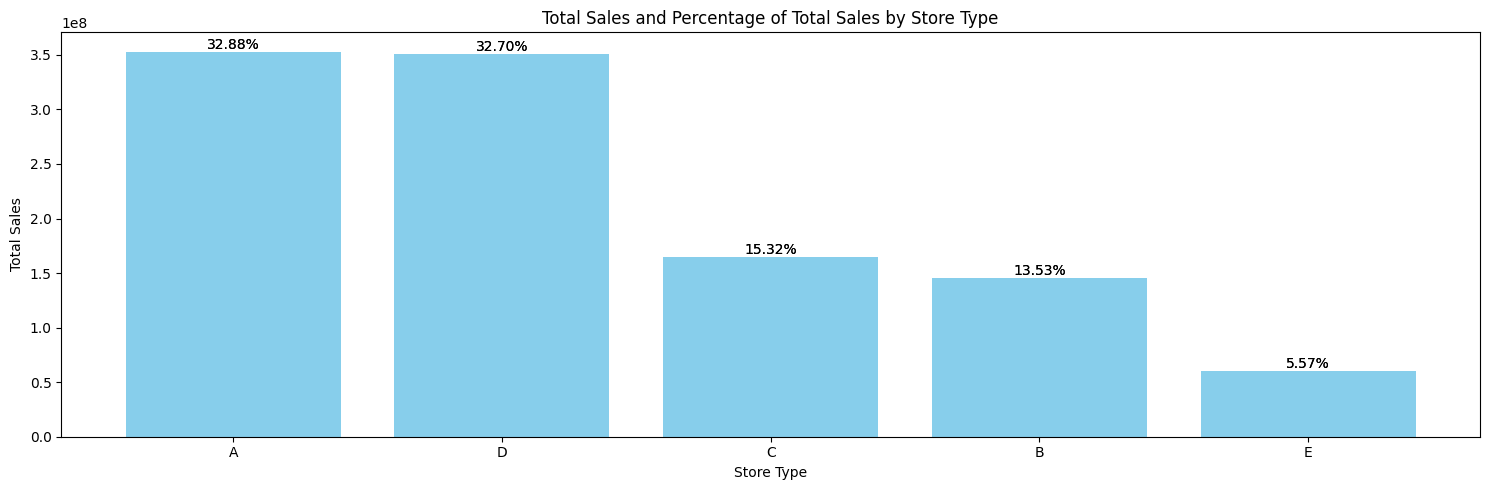

In [70]:
# Calculate total sales by store type
type_sales = str_train.groupby('type')['sales'].sum().sort_values(ascending=False)
print(type_sales.map('{:,.2f}'.format))

# Calculate overall total sales
overall_sales = str_train['sales'].sum()

# Calculate the percentage of each store type's sales over the overall sales
percentage_sales = (type_sales / overall_sales) * 100

# Plot a barplot to visualize the total sales and percentage of sales by store type
fig, ax = plt.subplots(figsize=(15, 5))

# Plot total sales
ax.bar(type_sales.index, type_sales, color='skyblue', label='Total Sales')

# Add percentage labels on top of the bars
for i, percentage in enumerate(percentage_sales):
    ax.text(i, type_sales[i] + 500, f"{percentage:.2f}%", ha='center', va='bottom', color='black')

# Add percentage of total sales as text above each bar
ax.bar_label(ax.containers[0], labels=[f"{percentage:.2f}%" for percentage in percentage_sales], label_type='edge', color='black')

ax.set_ylabel('Total Sales')
ax.set_xlabel('Store Type')
ax.set_title('Total Sales and Percentage of Total Sales by Store Type')
plt.tight_layout()
plt.show()

Notes
- Store types are A and D are the best performers with 32.88 and 32.7 percent sales respectively

- Store types E are the worst performers with 5.57%

**6. Are sales affected by promotions, oil prices and holidays?**

1. Are sales affected by promotions

In [71]:
df_train_cp

,id,store_nbr,family,sales,onpromotion,onpromotion_encoded,year,month
date,,,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.000,0,0,2013,January
2013-01-01,1,1,BABY CARE,0.000,0,0,2013,January
2013-01-01,2,1,BEAUTY,0.000,0,0,2013,January
2013-01-01,3,1,BEVERAGES,0.000,0,0,2013,January
2013-01-01,4,1,BOOKS,0.000,0,0,2013,January
...,...,...,...,...,...,...,...,...
2017-08-15,3000883,9,POULTRY,438.133,0,0,2017,August
2017-08-15,3000884,9,PREPARED FOODS,154.553,1,1,2017,August
2017-08-15,3000885,9,PRODUCE,2419.729,148,1,2017,August


In [72]:
# Create a date colum
df_train_cp['date'] = df_train_cp.index

In [73]:
# Drop index
df_train_cp= df_train_cp.reset_index(drop=True)

# Create DataFrame with dates from train_missing_dates
train_missing_dates_df = pd.DataFrame(dftrain_missing_dates, columns=['date'])

# Merge train_data_cp and train_missing_dates_df using outer join on the 'date' column

merged_train_df = pd.merge(df_train_cp, train_missing_dates_df, how='outer', on='date')

# Fill missing data using interpolation
merged_train_df['sales'].interpolate(inplace=True)

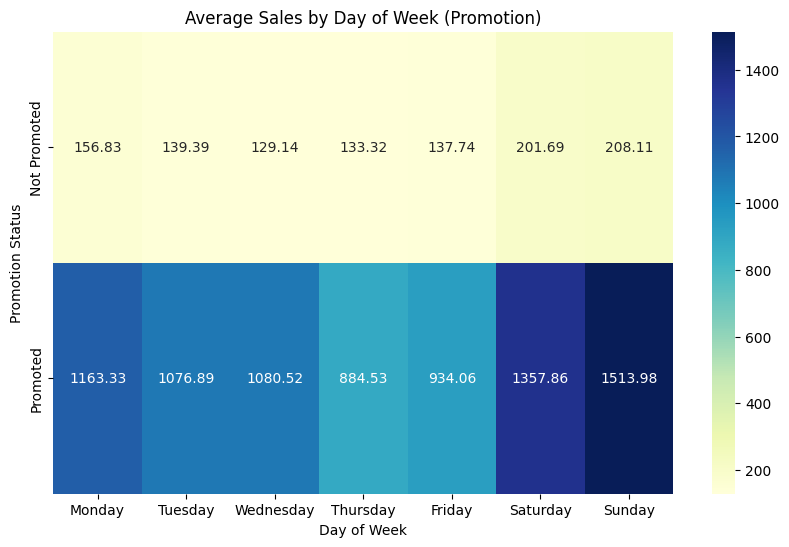

In [74]:
# Create dayofweek column
merged_train_df['dayofweek'] = merged_train_df['date'].dt.dayofweek
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(10, 6))

# Pivot table with 'dayofweek' as rows and 'onpromotion_encoded' as columns
pivot_table = merged_train_df.pivot_table(index='onpromotion_encoded', columns='dayofweek', values='sales', aggfunc='mean')

# Plot heatmap
ax = sns.heatmap(pivot_table, cmap='YlGnBu', annot=True, fmt='.2f')

# Set x-axis labels to custom day names
ax.set_xticklabels(day_names)

# Set y-axis labels to promotion status
ax.set_yticklabels(['Not Promoted', 'Promoted'])

plt.title('Average Sales by Day of Week (Promotion)')
plt.xlabel('Day of Week')
plt.ylabel('Promotion Status')
plt.show()

Sales
- Promotion significantly boost sales
- In all the days of the week, most sales were made from promoted products
- This suggests that targeted weekday promotions could be particularly effective in driving sales.

2. Are sales affected by oil prices

In [75]:
# Check for missing_dates in the oil data
print(f"First date: {oil_data['date'].min()}") # Check firt date

print(f"Last date: {oil_data['date'].max()}") # Check Last date 

expected_oil_dates = pd.date_range(start=oil_data['date'].min(), end=oil_data['date'].max(), freq='D') 

print(f'Expected dates: {len(expected_oil_dates)}')
print(f'Actaual dates: {len(oil_data)}')

First date: 2013-01-01
Last date: 2017-08-31
Expected dates: 1704
Actaual dates: 1218


In [76]:
# Filter out the dates that are missing in the oil_data DataFrame
missing_dates = expected_oil_dates[~expected_oil_dates.isin(oil_data['date'])]
missing_df = pd.DataFrame({'date': missing_dates})

# Concatenate oil_data and missing_df using outer join on the 'date' column
merged_oil_df = pd.concat([oil_data, missing_df], ignore_index=True)
merged_oil_df['date'] = pd.to_datetime(merged_oil_df['date'])  # Convert 'date' column to datetime type
merged_oil_df = merged_oil_df.sort_values('date').reset_index(drop=True)
merged_oil_df.bfill(inplace=True)

In [77]:
# Convert 'date' columns to datetime
merged_oil_df['date'] = pd.to_datetime(merged_oil_df['date'])
df_train['date'] = pd.to_datetime(df_train['date'])

# Merge the dataframes on 'date' column
merged_data = merged_oil_df.merge(df_train, how='left', on='date')

# Check for NaN values in the 'dcoilwtico' column
nan_count = merged_data['dcoilwtico'].isna().sum()
print(f'Number of NaN values in dcoilwtico: {nan_count}')


Number of NaN values in dcoilwtico: 0


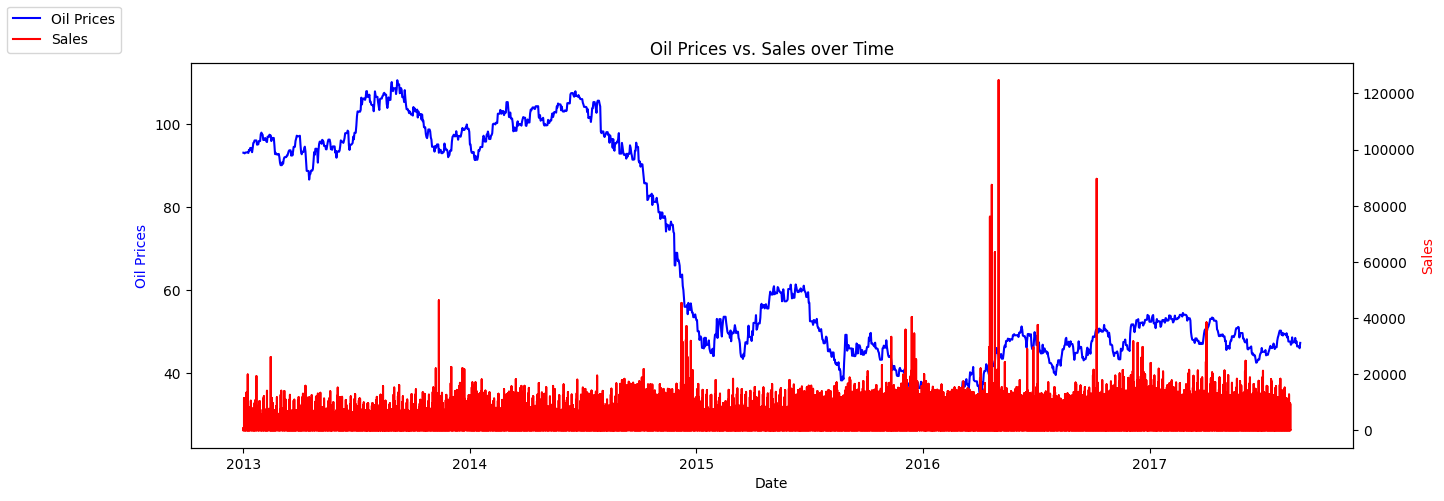

In [78]:
# Create a figure and axis objects
fig, ax1 = plt.subplots(figsize=(15, 5))

# Plot oil prices on the primary y-axis
ax1.plot(merged_data['date'], merged_data['dcoilwtico'], color='blue', label='Oil Prices')
ax1.set_xlabel('Date')
ax1.set_ylabel('Oil Prices', color='blue')

# Create a secondary y-axis for sales
ax2 = ax1.twinx()
ax2.plot(merged_data['date'], merged_data['sales'], color='red', label='Sales')
ax2.set_ylabel('Sales', color='red')

# Add a legend
fig.legend(loc='upper left')

plt.title('Oil Prices vs. Sales over Time')

# Show plot
plt.show()

In [79]:
# Check for any missimg values in the merged data before doing a pearson correlation
merged_data['sales'].isna().sum()

20

In [80]:
# Drop rows with missing values in 'sales' columns
merged_data['sales'].isna().sum()
cleaned_data = merged_data.dropna(subset=['sales'])

# Calculate the Pearson correlation coefficient between oil prices and sales
correlation = np.corrcoef(cleaned_data['dcoilwtico'], cleaned_data['sales'])[0, 1]

print(f"Pearson correlation coefficient between oil prices and sales: {correlation}")

Pearson correlation coefficient between oil prices and sales: -0.07503571424899075


Notes
- A negative correlation between oil prices and sales means that as oil prices increase, sales tend to decrease, and vice versa.

- A Pearson correlation coefficient of approximately -0.075 suggests a very weak negative correlation between oil prices and sales. This means that there is a slight tendency for sales to decrease as oil prices increase, but the correlation is not strong.

- Keep in mind that correlation does not imply causation, and there could be other factors influencing the relationship between oil prices and sales. Additionally, a correlation coefficient close to zero indicates a weak linear relationship, so it's essential to consider other factors that may affect sales.

3. Are sales affected by holidays

In [81]:
# Get number of holidays
holidays_events_data['type'].value_counts()

type
Holiday       221
Event          56
Additional     51
Transfer       12
Bridge          5
Work Day        5
Name: count, dtype: int64

In [82]:
# get holidays_events_data info
holidays_events_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   date         350 non-null    object
 1   type         350 non-null    object
 2   locale       350 non-null    object
 3   locale_name  350 non-null    object
 4   description  350 non-null    object
 5   transferred  350 non-null    bool  
dtypes: bool(1), object(5)
memory usage: 14.1+ KB


In [83]:
# Covert date to date time 

holidays_events_data['date'] = pd.to_datetime(holidays_events_data['date'])

In [84]:
# merge train and holidays dataset

merge_train_hols = df_train_cp.merge(holidays_events_data, how='left', on=['date'])
    
merge_train_hols.reset_index()
merge_train_hols.head()

,id,store_nbr,family,sales,onpromotion,onpromotion_encoded,year,month,date,type,locale,locale_name,description,transferred
0,0,1,AUTOMOTIVE,0.0,0,0,2013,January,2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False
1,1,1,BABY CARE,0.0,0,0,2013,January,2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False
2,2,1,BEAUTY,0.0,0,0,2013,January,2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False
3,3,1,BEVERAGES,0.0,0,0,2013,January,2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False
4,4,1,BOOKS,0.0,0,0,2013,January,2013-01-01,Holiday,National,Ecuador,Primer dia del ano,False


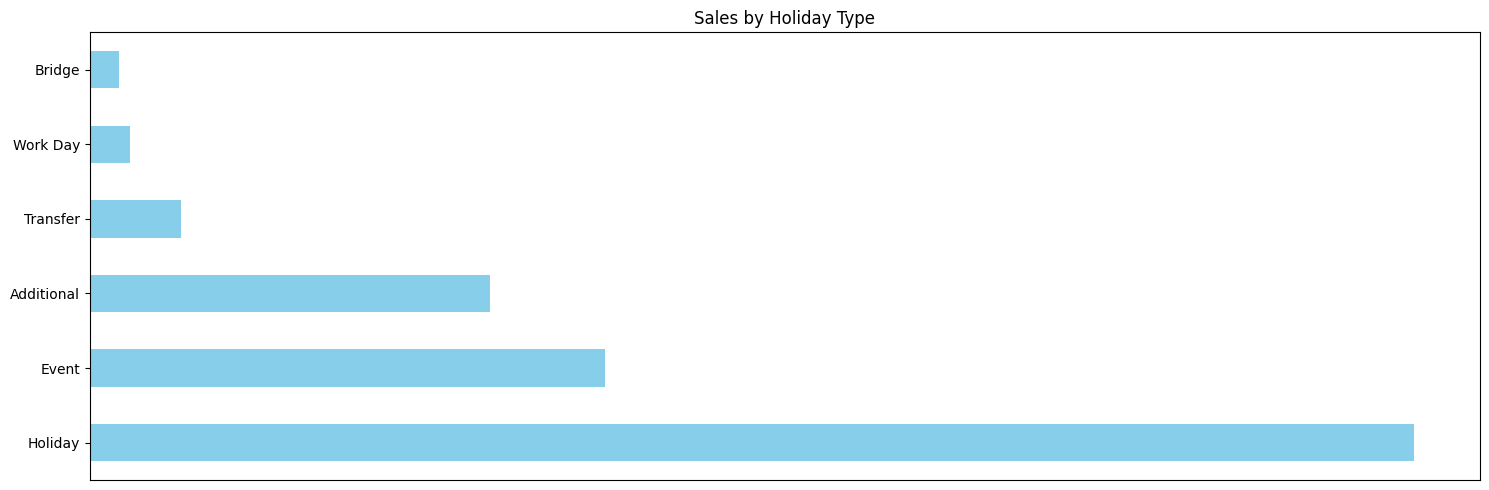

In [85]:
# Group the data by holiday type and calculate the sum of sales for each type
sales_by_holiday_type = merge_train_hols.groupby("type").agg({"sales": "sum"}).sort_values(by="sales", ascending=False)

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(15, 5))

# Plot a horizontal bar chart of the sales by holiday type
sales_by_holiday_type.plot(kind="barh", ax=ax, color='skyblue')

# Add a title and labels
ax.set_title("Sales by Holiday Type")
ax.set_ylabel("Holiday Type")
ax.legend().set_visible(False)
plt.xticks([])
plt.ylabel('')
plt.tight_layout()
plt.show()

Notes
- Most salses are made on normal holiday
- Least sales are made on Bridged holiday

7. What analysis can we get from the date and its extractable features?

1 Sales by month

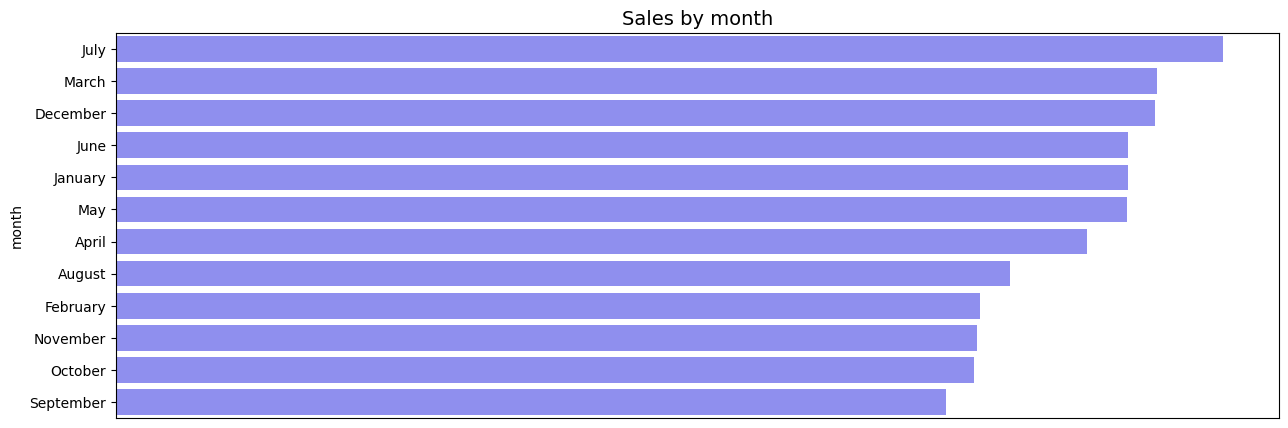

In [86]:
# Plotting a bar plot to show total sales by month
sales_by_month = df_train_cp.groupby('month')['sales'].sum().sort_values(ascending=False)
plt.figure(figsize=(15, 5))
av = sns.barplot(y=sales_by_month.index, x=sales_by_month.values, color='blue', alpha=0.5,)
plt.xticks([])
plt.title('Sales by month', fontsize=14)
plt.show()

Notes
- Most sales are made in July and March. This can be attributed to the
- summer holiday season and end-of-quarter business activities.

2. Sales by day of the week

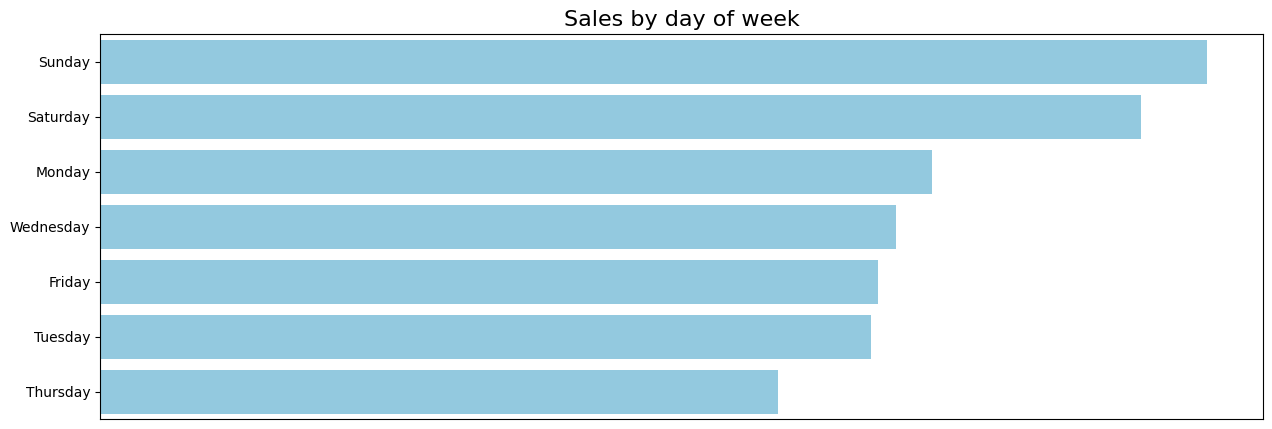

In [87]:
# Plotting a bar plot to show total sales by DAY OF THE WEEK

df_train_cp['day_of_week'] = df_train_cp['date'].dt.day_name()
sales_by_day = df_train_cp.groupby('day_of_week')['sales'].sum().sort_values(ascending=False)
plt.figure(figsize=(15,5))
av = sns.barplot(y=sales_by_day.index, x=sales_by_day.values, color='skyblue')
plt.title('Sales by day of week', fontsize=16)
plt.ylabel('')
plt.xticks([])
plt.show()

Notes
- Weekends have the most sales while thursdays gave the least sales

3. Sales by day of Quarter

quarter
2    2.795840e+08
1    2.723079e+08
3    2.643091e+08
4    2.574440e+08
Name: sales, dtype: float64


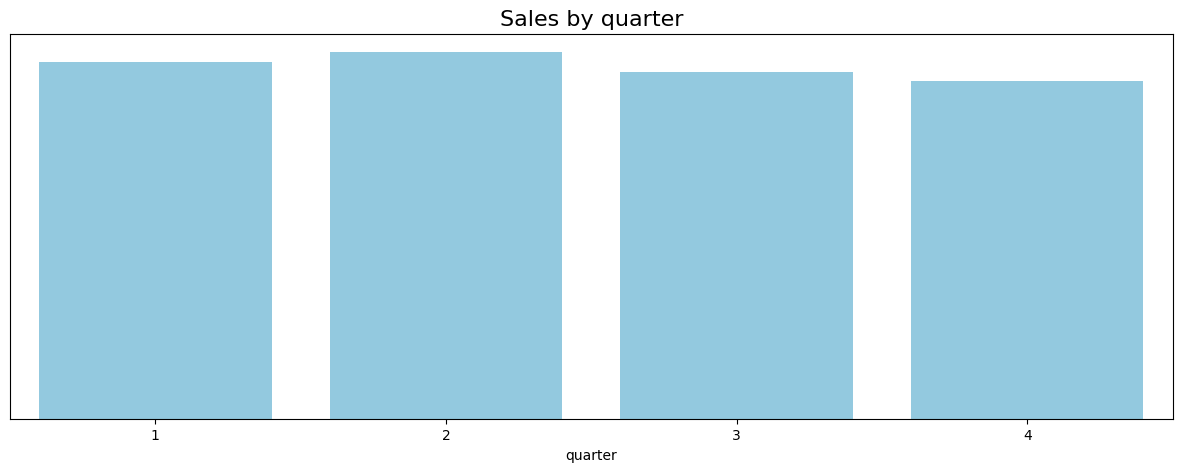

In [88]:
# Bar graph to show sales by quarter
df_train_cp['quarter'] = df_train_cp['date'].dt.quarter
sales_by_quarter = df_train_cp.groupby('quarter')['sales'].sum().sort_values(ascending=False)
print(sales_by_quarter)
plt.figure(figsize=(15,5))
av = sns.barplot(x=sales_by_quarter.index, y=sales_by_quarter.values, color='skyblue')
plt.title('Sales by quarter', fontsize=16)
plt.xticks(rotation=0)
plt.yticks([])
plt.show()

Notes
- All quarters are relatively close to each other
- No major differences are noted

4. Sales by day of the Month

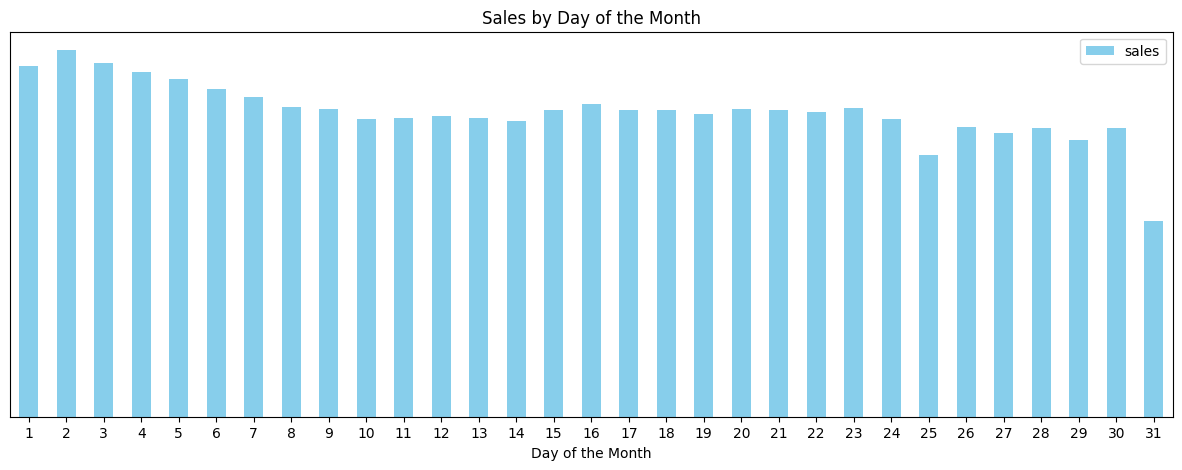

In [89]:
# Sales by day of the month
df_train_cp['day_of_month'] = df_train_cp['date'].dt.day
sales_by_day_of_month = df_train_cp.groupby('day_of_month')['sales'].sum()
sales_by_day_of_month.plot(kind='bar', figsize=(15, 5),
                            xlabel='Day of the Month', 
                            ylabel='Total Sales', 
                            title='Sales by Day of the Month',
                            color='skyblue')
plt.xticks(rotation='horizontal')
plt.yticks([])
plt.ylabel('')
plt.legend(loc = 'upper right')
plt.show()

Notes
- Highest sales occur on the 2nd of the month, indicating strong start-of-month performance.
- Sales decrease towards month-end, with the 31st having the lowest sales.
- From the 10th to the 20th, sales remain relatively stable around.
- Within mid-month consistency, there's a slight peak around the 15th.
- Sales hit a low on the 25th, warranting further investigation.

8. Which product family and stores did the promotions affect?

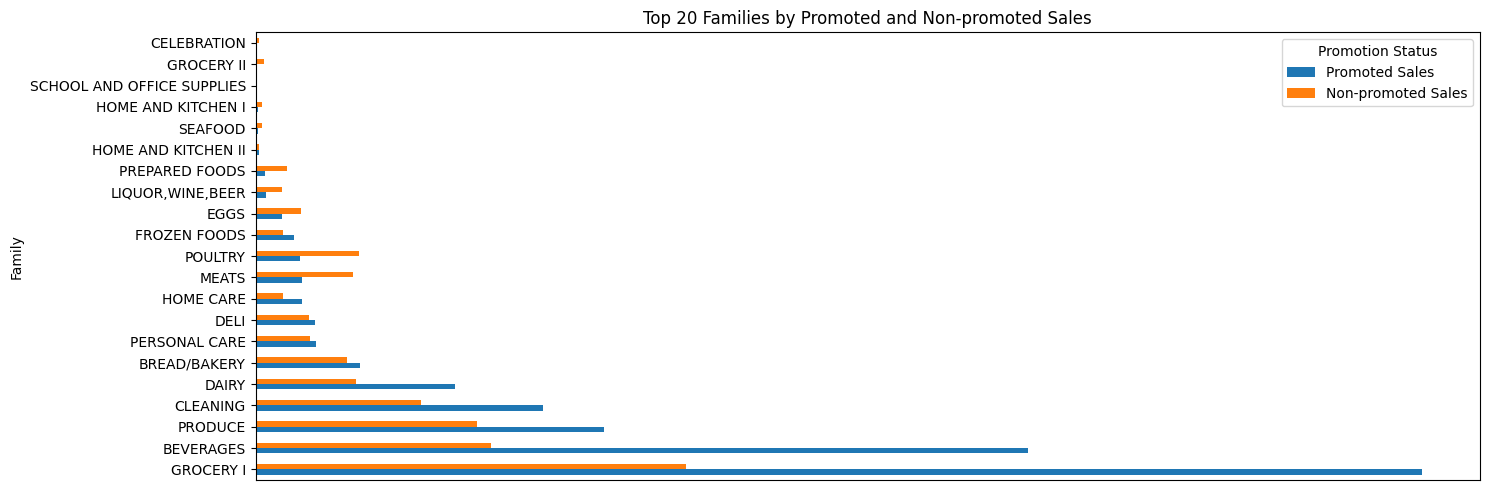

In [90]:
# Filter the DataFrame to include only rows where onpromotion_encoded is equal to 1
promoted_data = df_train_cp[df_train_cp['onpromotion_encoded'] == 1]
non_promoted_data = df_train_cp[df_train_cp['onpromotion_encoded'] == 0]

# Group by the family column and sum up the sales for each group, then sort the result
grouped_sales_promotion = promoted_data.groupby('family')['sales'].sum().sort_values(ascending=False).head(20)
non_promoted_data_grp = non_promoted_data.groupby('family')['sales'].sum().sort_values(ascending=False).head(20)

# Rename columns for clarity
grouped_sales_promotion = grouped_sales_promotion.rename('Promoted Sales')
non_promoted_data_grp = non_promoted_data_grp.rename('Non-promoted Sales')

# Convert the result to a DataFrame
grouped_sales_promotion = pd.concat([grouped_sales_promotion, non_promoted_data_grp], axis=1)

# Plotting
grouped_sales_promotion.plot(kind='barh', figsize=(15, 5))
plt.title('Top 20 Families by Promoted and Non-promoted Sales')
plt.ylabel('Family')
plt.xticks([])
plt.legend(title='Promotion Status')
plt.tight_layout()
plt.show()

Notes
- Grocery I is the most affected product family
- The effect is positive since most sales were made from the promoted items

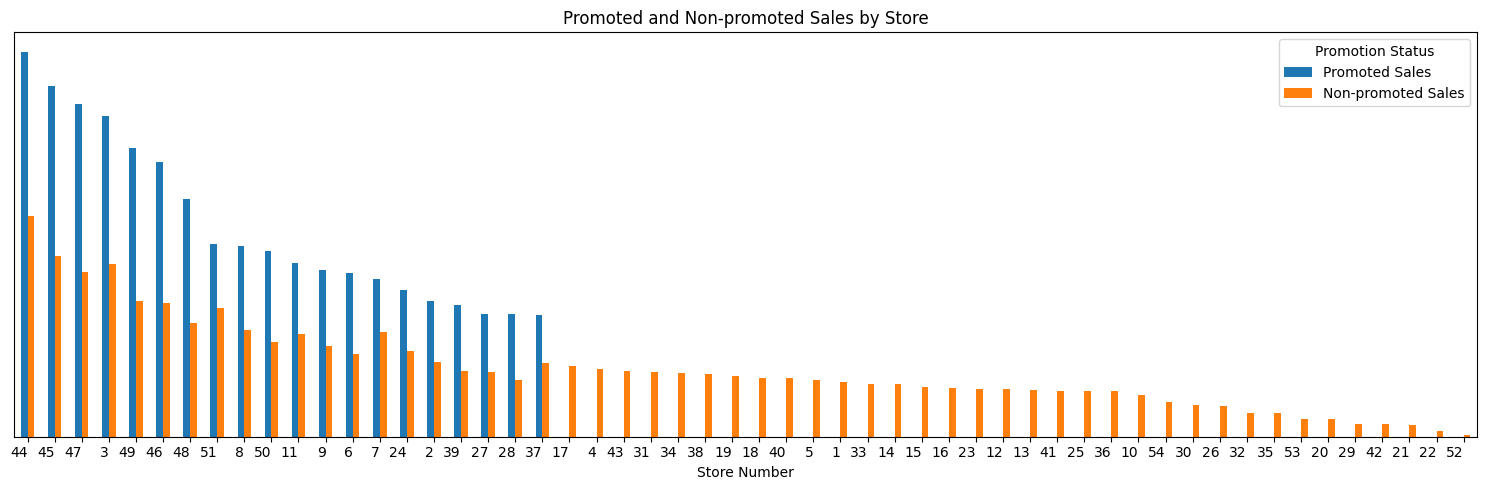

In [91]:
# Group by the family column and sum up the sales for each group, then sort the result
grouped_sales_promotion_str = promoted_data.groupby('store_nbr')['sales'].sum().sort_values(ascending=False).head(20)
non_promoted_data_grp_str = non_promoted_data.groupby('store_nbr')['sales'].sum().sort_values(ascending=False)

# Rename columns for clarity
grouped_sales_promotion_str = grouped_sales_promotion_str.rename('Promoted Sales')
non_promoted_data_grp_str = non_promoted_data_grp_str.rename('Non-promoted Sales')

# Convert the result to a DataFrame
grouped_sales_promotion_str = pd.concat([grouped_sales_promotion_str, non_promoted_data_grp_str], axis=1)

# Plotting
grouped_sales_promotion_str.plot(kind='bar', figsize=(15, 5))
plt.title('Promoted and Non-promoted Sales by Store')
plt.xlabel('Store Number')
plt.yticks([])
plt.xticks(rotation=0, ha='right')
plt.legend(title='Promotion Status')
plt.tight_layout()
plt.show()

Notes
- The effect of promotion on store sales is a positive one. Most sales were from promoted items
- The effect positive effect of promotion on store sales is clearly evident in store 44 the store with most sales

9. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

1. Root Mean Squared Logarithmic Error (RMSLE):

- What it measures: How accurately the model predicts the target variable when its values vary widely.
- How it's calculated: First, it takes the logarithm of both the predicted and actual values. Then, it calculates the squared differences between these logarithms. Finally, it computes the mean of these squared differences and takes the square root.
- Why it's used Useful when you care more about relative errors across the entire range of the target variable. Root Mean Squared Error (RMSE):
- What it measures: The average size of the errors between predicted and actual values.
- How it's calculated: It calculates the squared differences between predicted and actual values, then computes the mean of these squared differences, and finally takes the square root.
- Why it's used: Helps in understanding the overall accuracy of the model's predictions.

2. Mean Squared Error (MSE):

- What it measures: Similar to RMSE, but without taking the square root.
- How it's calculated: It calculates the squared differences between predicted and actual values, then computes the mean of these squared differences.
- Why it's used: Provides a measure of the average magnitude of errors, but the unit is different from the target variable.

3. Mean Absolute Error (MAE):

- What it measures: The average absolute size of the errors between predicted and actual values.
- How it's calculated: It calculates the absolute differences between predicted and actual values, then computes the mean of these absolute differences.
- Why it's used: Gives a simple and easy-to-understand measure of prediction accuracy, especially when dealing with outliers.

**MAE can be greater than other metrics when there are large errors or outliers in the data because it treats all errors equally and doesn't square them. MAE counts all errors the same way, whether they're too high or too low. So, if there are some really big errors in our predictions, MAE adds them up just like the smaller errors, which can make its total bigger. The other metrics like RMSE or MSE handle these big errors differently, so they might not end up as big as MAE**

10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.

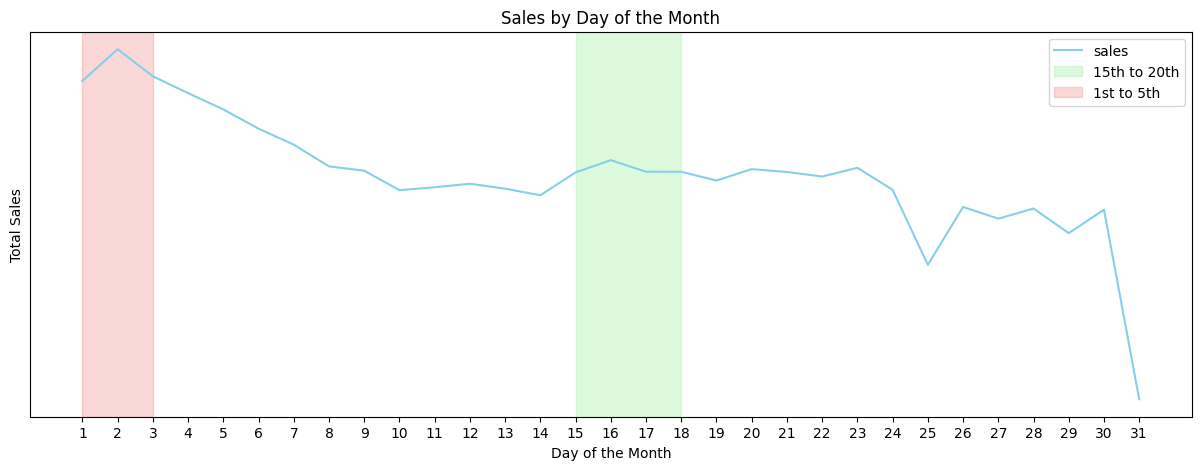

In [92]:
# Sales by day of the month
df_train_cp['day_of_month'] = df_train_cp['date'].dt.day
sales_by_day_of_month = df_train_cp.groupby('day_of_month')['sales'].sum()
sales_by_day_of_month.plot(kind='line', figsize=(15, 5),
                            xlabel='Day of the Month', 
                            ylabel='Total Sales', 
                            title='Sales by Day of the Month',
                            color='skyblue')

# Highlighting different periods with different colors
plt.axvspan(15, 18, color='lightgreen', alpha=0.3, label='15th to 20th')
plt.axvspan(1, 1 + 2, color='lightcoral', alpha=0.3, label='1st to 5th')

plt.xticks(range(1, 32), rotation='horizontal')
plt.yticks([])
plt.legend()
plt.show()

Notes
- After people get paid at the end of the month, sales go up. They peak around the second day of the month before coming down and stabilizing around the seventh day of the month.

- Sales also slightly rise after the 15th of the month payday, but not as much.

### **Data Preparation**

**Handling missing dates**

In [93]:
# Convert missing dates data to a dataframe
train_missing_dates = pd.DataFrame(dftrain_missing_dates).rename(columns={0: 'date'})
train_missing_dates

,date
0,2013-01-01
1,2013-01-02
2,2013-01-03
3,2013-01-04
4,2013-01-05
...,...
1683,2017-08-11
1684,2017-08-12
1685,2017-08-13
1686,2017-08-14


In [94]:
# Handle the missing dates
train_complete_data = pd.merge(df_train, train_missing_dates, how='outer', on='date')

In [95]:
# Checking for null values
train_complete_data.isna().sum()

id             4
date           0
store_nbr      4
family         4
sales          4
onpromotion    4
dtype: int64

In [96]:
# Fill the missing values with interpolation
train_complete_data = train_complete_data.interpolate(method='linear', axis=0).ffill().bfill()

**Stationarity**

In [97]:
# Set up the training data
train_cols = ['date', 'sales']

train_daily_total_sales = train_complete_data[train_cols].set_index('date').resample('D').sum()
print(train_daily_total_sales.shape)
train_daily_total_sales.head()

(1688, 1)


,sales
date,
2013-01-01,2511.618999
2013-01-02,496092.417944
2013-01-03,361461.231124
2013-01-04,354459.677093
2013-01-05,477350.121229


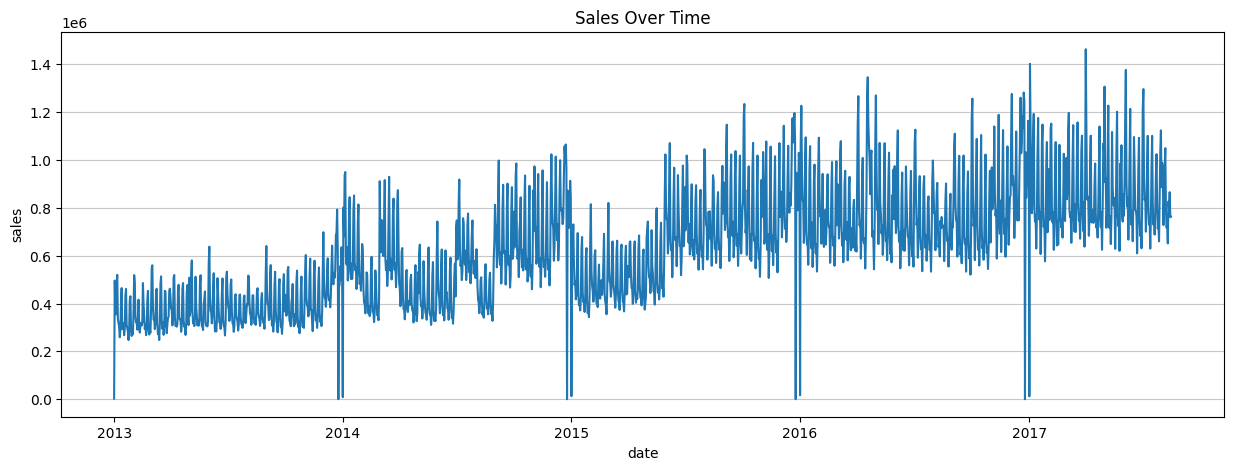

In [98]:
# Visualizing sales over time
plt.figure(figsize=(15, 5))
sns.lineplot(
    x=train_daily_total_sales.index, 
    y=train_daily_total_sales['sales']
    )
plt.title('Sales Over Time')
plt.grid(axis='y', alpha=0.7)
plt.show()

Notes
- We had done the kpss test before setting up our training data and established that the time series was not stationary
- We will do the adf test now that we have set up our training data to confirm before proceeding
- From the lineplot above, we can see that the time series has a clear upward trend and variations from the mean. This suggests non-stationarity. Hence, our Null hypothesis will be that the time series is non-stationary as we can infer from the the plot while the Null hypothesis will be that the time series is stationary

H0: The time series is non-stationary

HA: The time series is stationary

In [99]:
# ADF Test
# Function to perform ADF test and return results
def adf_test(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    return dfoutput

# Call the function and run the test
adf_results = adf_test(train_daily_total_sales['sales'])
if adf_results['p-value'] < 0.05:
    print('The time series is stationary.')
else:
    print('The time series is non-stationary.')

Results of Dickey-Fuller Test:
Test Statistic                   -2.571414
p-value                           0.099050
#Lags Used                       22.000000
Number of Observations Used    1665.000000
Critical Value (1%)              -3.434284
Critical Value (5%)              -2.863277
Critical Value (10%)             -2.567695
dtype: float64
The time series is non-stationary.


Notes
- The p-value obtained (0.10) is greater than the significance level of 0.05, and the Test Statistic (-2.57) is not more negative than any of the critical values.

- Therefore, based on these results, the null hypothesis cannot be rejected, indicating that there is insufficient evidence to conclude that the time series is stationary.

- This means we fail to reject the null hypothesis that the time series is non-stationary.

**Differencing**

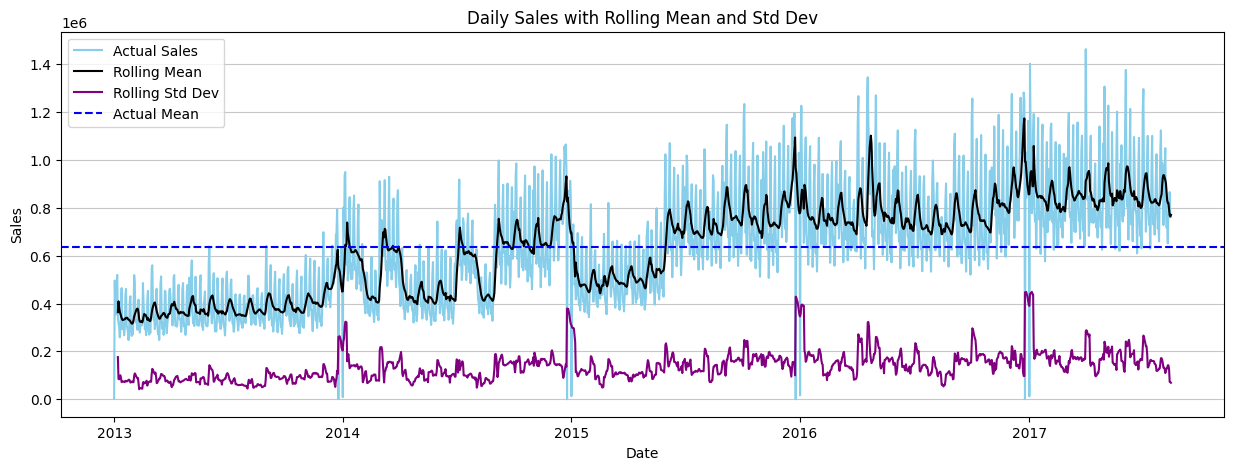

In [100]:
# Calculate mean and standard deviation of sales
sales_mean = train_daily_total_sales['sales'].mean()
sales_std = train_daily_total_sales['sales'].std()

# Plotting
plt.figure(figsize=(15, 5))

# Plot actual sales
plt.plot(train_daily_total_sales.index, train_daily_total_sales['sales'], label='Actual Sales', color='skyblue')

# Plot rolling mean
plt.plot(train_daily_total_sales.index, train_daily_total_sales['sales'].rolling(window=7).mean(), label='Rolling Mean', color='black',)

# Plot rolling standard deviation
plt.plot(train_daily_total_sales.index, train_daily_total_sales['sales'].rolling(window=7).std(), label='Rolling Std Dev', color='purple')

# Plot actual mean
plt.axhline(y=sales_mean, color='blue', linestyle='--', label='Actual Mean')

plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Daily Sales with Rolling Mean and Std Dev')
plt.legend()
plt.grid(axis='y', alpha=0.7)
plt.show()

Notes
- Rolling mean and standard deviation help in distinguishing signal (underlying trend or pattern) from noise (random fluctuations) in the data. By smoothing out noise, they make underlying patterns more apparent, aiding in decision-making and forecasting. Rolling mean smooths out short-term fluctuations and highlights longer-term trends in the data. This can help in identifying underlying patterns or trends that might not be apparent in the raw data.

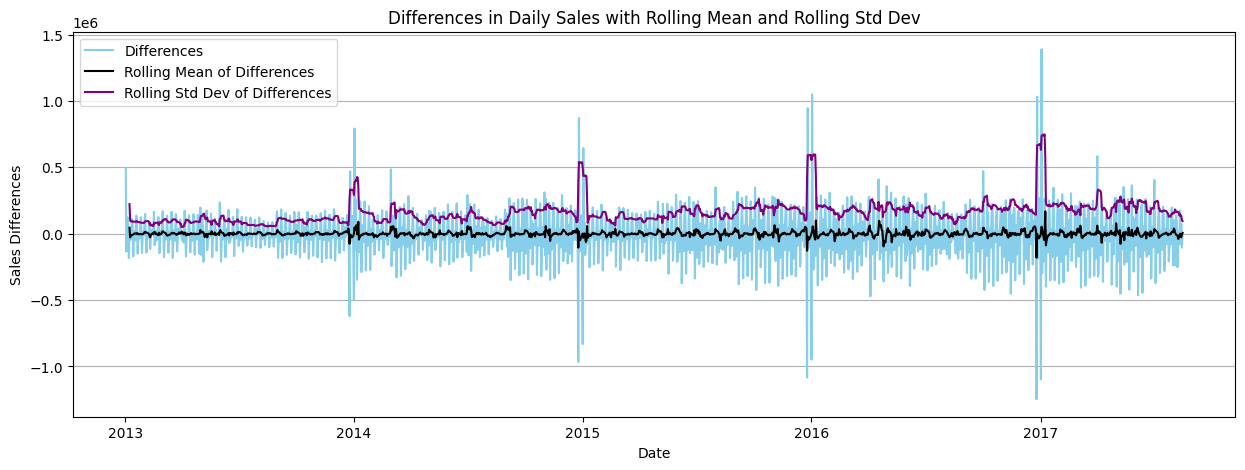

In [101]:
# Calculate differences
sales_diff = train_daily_total_sales['sales'].diff()

# Calculate rolling mean and standard deviation of differences
sales_diff_rolling_mean = sales_diff.rolling(window=7).mean()
sales_diff_std = sales_diff.rolling(window=7).std()

# Plotting
plt.figure(figsize=(15, 5))

# Plot differences
plt.plot(train_daily_total_sales.index, sales_diff, label='Differences', color='skyblue')

# Plot rolling mean of differences
plt.plot(train_daily_total_sales.index, sales_diff_rolling_mean, label='Rolling Mean of Differences', color='black')

# Plot rolling standard deviation of differences
plt.plot(train_daily_total_sales.index, sales_diff_std, label='Rolling Std Dev of Differences', color='purple')

plt.xlabel('Date')
plt.ylabel('Sales Differences')
plt.title('Differences in Daily Sales with Rolling Mean and Rolling Std Dev')
plt.legend()
plt.grid(axis='y')
plt.show()

In [102]:
#  Drop missing and infinite values
sales_diff_clean = sales_diff.dropna().replace([np.inf, -np.inf], np.nan).dropna()

# Call the function and run the test
adf_results_diff = adf_test(sales_diff_clean)

# Check if the p-value is less than 0.05
if adf_results_diff['p-value'] < 0.05:
    print('The time series is stationary.')
else:
    print('The time series is non-stationary.')

Results of Dickey-Fuller Test:
Test Statistic                -1.131158e+01
p-value                        1.235230e-20
#Lags Used                     2.500000e+01
Number of Observations Used    1.661000e+03
Critical Value (1%)           -3.434293e+00
Critical Value (5%)           -2.863282e+00
Critical Value (10%)          -2.567697e+00
dtype: float64
The time series is stationary.


Notes
- Our time series is now stationary

In [103]:
# Combining the original time series and the differenced time series
train_daily_total_sales['diff_sales'] = sales_diff_clean
train_daily_total_sales['diff_sales_7'] = train_daily_total_sales['sales'].dropna().replace([np.inf, -np.inf], np.nan).dropna().diff(7)

train_daily_total_sales.head()

,sales,diff_sales,diff_sales_7
date,,,
2013-01-01,2511.618999,NaN,NaN
2013-01-02,496092.417944,493580.798945,NaN
2013-01-03,361461.231124,-134631.186820,NaN
2013-01-04,354459.677093,-7001.554031,NaN
2013-01-05,477350.121229,122890.444136,NaN


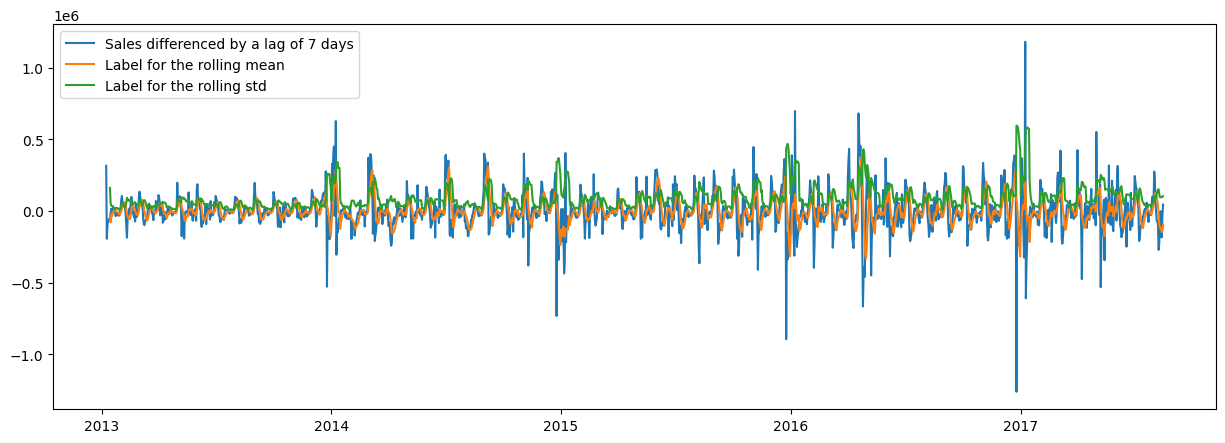

In [104]:
# Plot a figure showing sales differenced by a lag of 7
plt.figure(figsize=(15,5))
plt.plot(train_daily_total_sales['diff_sales_7'].dropna(), label='Sales differenced by a lag of 7 days')
plt.plot(train_daily_total_sales['diff_sales_7'].dropna().rolling(window=7).mean(), label='Label for the rolling mean')
plt.plot(train_daily_total_sales['diff_sales_7'].dropna().rolling(window=7).std(), label='Label for the rolling std')
plt.legend(loc='upper left',)

plt.show()

### **Modelling**

Splitting the data

In [105]:
# Split the data into train and test
train = train_daily_total_sales.loc[train_daily_total_sales.index < "2017-06-01"]
test = train_daily_total_sales.loc[train_daily_total_sales.index >= "2017-06-01"]

In [106]:
# Shape of data
train.shape, test.shape

((1612, 3), (76, 3))

**1. SARIMA Model**

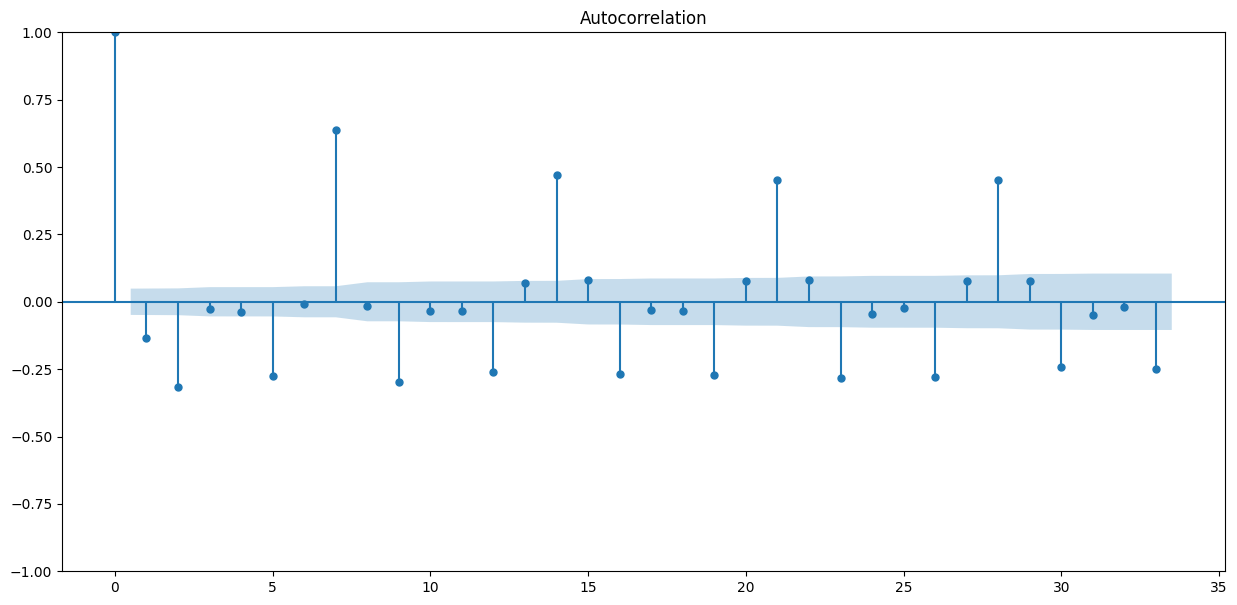

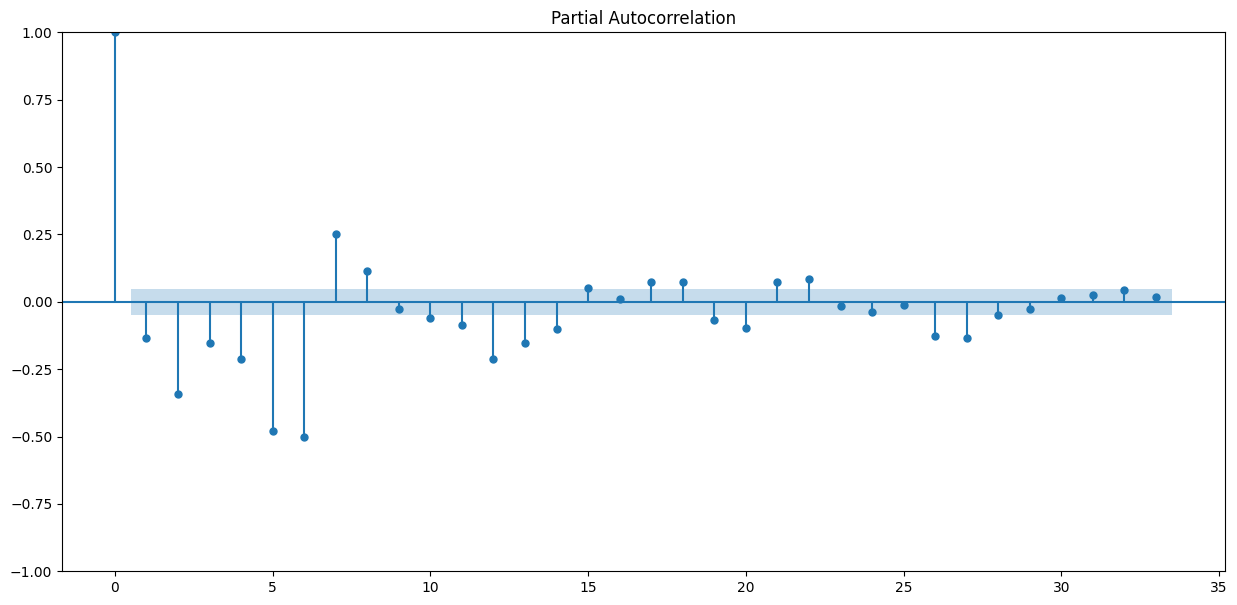

In [107]:
# Plotting acf and pcf
acf = plot_acf(train['diff_sales'].dropna())
pacf = plot_pacf(train['diff_sales'].dropna())

In [108]:
# Model instatiation
sarima_model = auto_arima(
    train['diff_sales'].dropna(),
    seasonal=True,
    m=7,
    stepwise=True,
    )

# Model summary
print(sarima_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1611
Model:             SARIMAX(4, 0, 2)x(1, 0, 2, 7)   Log Likelihood              -20967.982
Date:                           Wed, 31 Jul 2024   AIC                          41957.965
Time:                                   17:58:43   BIC                          42017.195
Sample:                               01-02-2013   HQIC                         41979.951
                                    - 05-31-2017                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1449.6889    724.179      2.002      0.045      30.325    2869.053
ar.L1         -1.5744      0.104    -15.178

In [109]:
# Get model order
print(f'Sarima model order: {sarima_model.order}')

# Get model seasonal order
print(f'Sarima model seasonal order: {sarima_model.seasonal_order}')

Sarima model order: (4, 0, 2)
Sarima model seasonal order: (1, 0, 2, 7)


In [110]:
# Fit data into the model
sarima_model_fit = sarima_model.fit(train['diff_sales'].dropna())
sarima_model_fit

ARIMA(order=(4, 0, 2), scoring_args={}, seasonal_order=(1, 0, 2, 7),
      suppress_warnings=True)

In [111]:
# Predict
period_predict = len(test['diff_sales'].dropna())

sarima_model_predict = sarima_model_fit.predict(n_periods=period_predict, order=sarima_model.order)

In [112]:
# Model Evaluation
mae = mean_absolute_error(test['diff_sales'].dropna(), sarima_model_predict)
rmse = np.sqrt(mean_squared_error(test['diff_sales'].dropna(), sarima_model_predict))

# RMSLE
def rmsle(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

rmsle_value = rmsle(test['diff_sales'].dropna(), sarima_model_predict) 


print('SARIMA Model metrics:')
print(f'RMSLE: {rmsle_value}')

print(f'MAE: {mae}')

print(f'RMSE: {rmse}')

SARIMA Model metrics:
RMSLE: 0.7838511563900664
MAE: 60060.72451096714
RMSE: 82587.1858085902


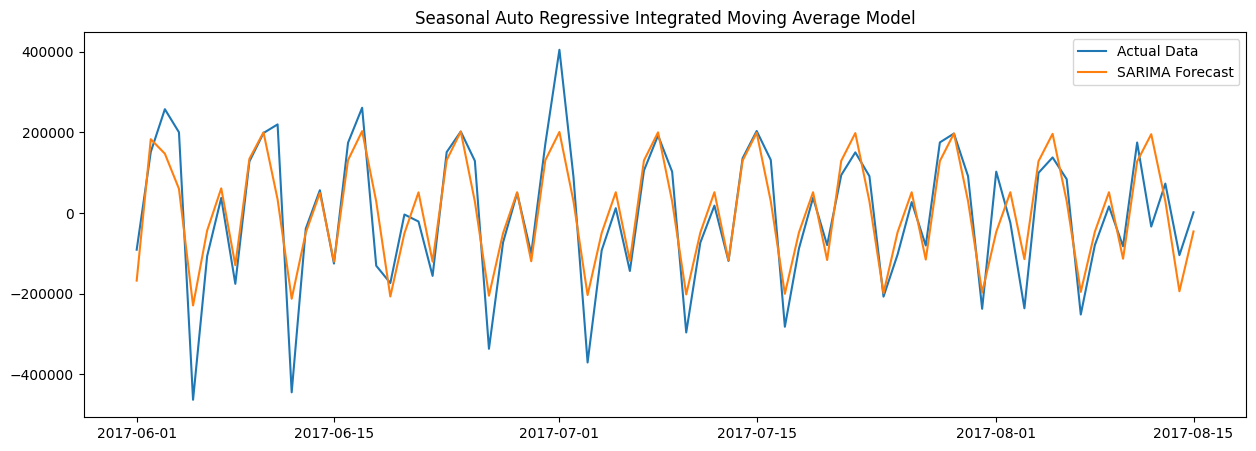

In [113]:
# plot the train, evaluation and model predictions
plt.figure(figsize = (15,5))
plt.plot(test['diff_sales'], label = 'Actual Data')
plt.plot (sarima_model_predict, label = 'SARIMA Forecast')
plt.legend(loc='upper right')
plt.title('Seasonal Auto Regressive Integrated Moving Average Model')
plt.show()

**2. ARIMA**

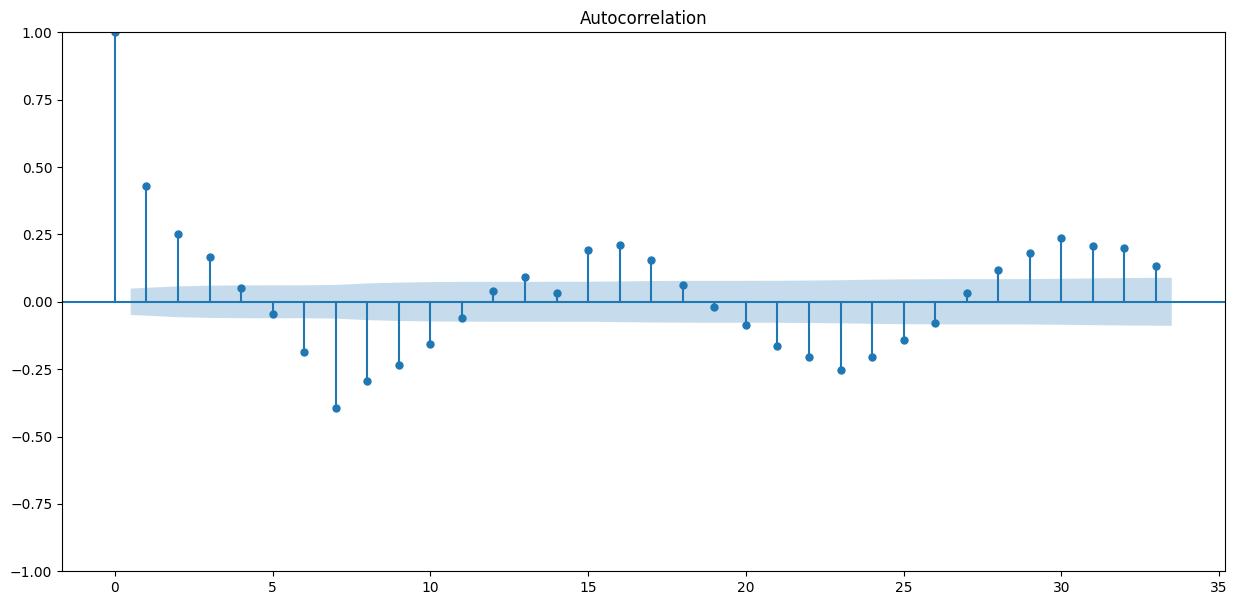

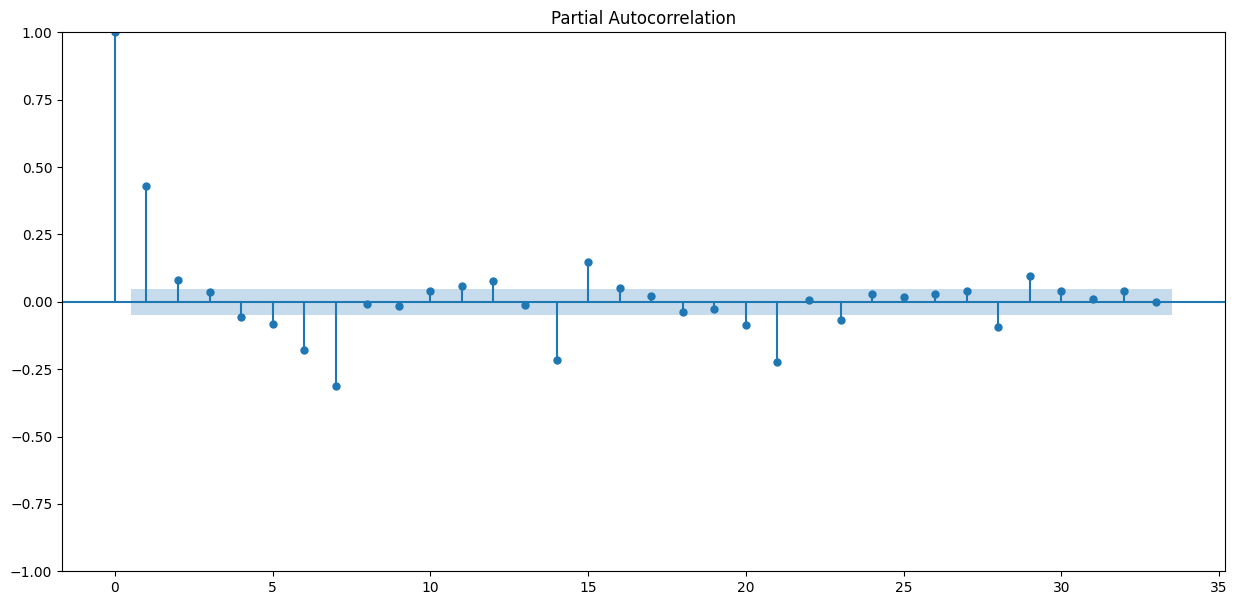

In [114]:
# Plotting acf and pcf
acf = plot_acf(train['diff_sales_7'].dropna())
pacf = plot_pacf(train['diff_sales_7'].dropna())

In [115]:
arima_model = auto_arima(
    train['diff_sales_7'].dropna(),
    seasonal=False,
    m=7,
    stepwise=True,
    d=0 
)

In [116]:
# Get model and seasonal orders

print(f'ARIMA model order: {arima_model.order}')

print(f'ARIMA model seasonal order: {arima_model.seasonal_order}')

ARIMA model order: (2, 0, 3)
ARIMA model seasonal order: (0, 0, 0, 0)


In [117]:
# Fit data into ARIMA model

arima_model_fit = arima_model.fit(train['diff_sales_7'].dropna(), order=arima_model.order)

# Do the predictions

period_predict = len(test['diff_sales_7'].dropna())

arima_model_predict = arima_model_fit.predict(n_periods=period_predict)

# Model Evaluation

mae = mean_absolute_error(test['diff_sales_7'].dropna(), arima_model_predict)

rmse = np.sqrt(mean_squared_error(test['diff_sales_7'].dropna(), arima_model_predict))

# RMSLE
def rmsle(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    return np.sqrt(np.mean(np.square(np.log1p(y_pred) - np.log1p(y_true))))

rmsle_value = rmsle(test['diff_sales'].dropna(), arima_model_predict) 

print('ARIMA Model Metrics:')

print(f'MAE: {mae}')

print(f'RMSE: {rmse}')

print(f'RMSLE: {rmsle_value}')

ARIMA Model Metrics:
MAE: 79652.34348836508
RMSE: 104271.24628892526
RMSLE: 2.1155238894170676


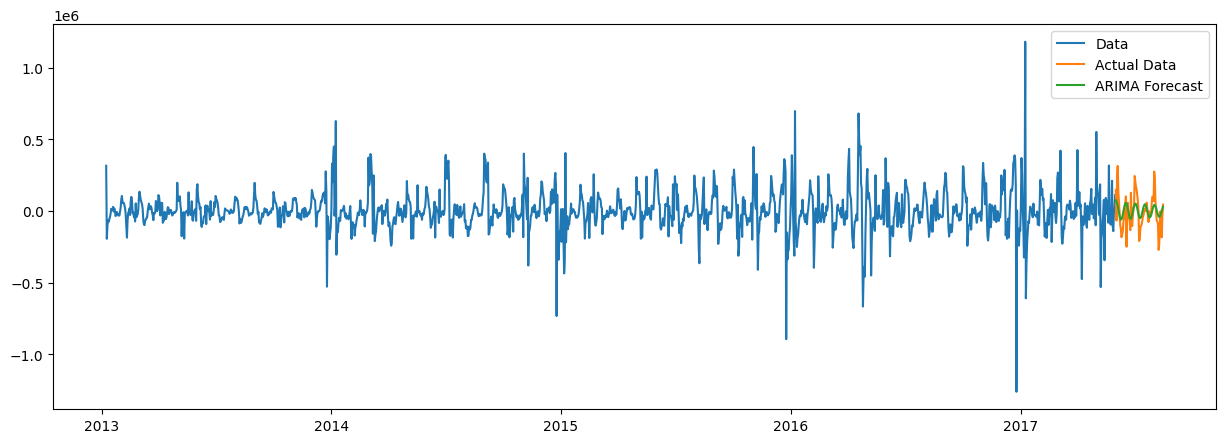

In [118]:
# PLot the model

plt.figure(figsize = (15,5))

plt.plot(train['diff_sales_7'], label = 'Data')
plt.plot(test['diff_sales_7'], label = 'Actual Data')

plt.plot (arima_model_predict, label = 'ARIMA Forecast')

plt.legend(loc='upper right')

3. **XGB Regressor and Linear Regression**

In [119]:
train_complete_data.head()

,id,date,store_nbr,family,sales,onpromotion
0,0.0,2013-01-01,1.0,AUTOMOTIVE,0.0,0.0
1,1.0,2013-01-01,1.0,BABY CARE,0.0,0.0
2,2.0,2013-01-01,1.0,BEAUTY,0.0,0.0
3,3.0,2013-01-01,1.0,BEVERAGES,0.0,0.0
4,4.0,2013-01-01,1.0,BOOKS,0.0,0.0


In [120]:
train_complete_data.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

In [121]:
# Drop ID column
train_complete_data = train_complete_data.drop(['id'], axis=1)

train_complete_data.head(2)

,date,store_nbr,family,sales,onpromotion
0,2013-01-01,1.0,AUTOMOTIVE,0.0,0.0
1,2013-01-01,1.0,BABY CARE,0.0,0.0


In [122]:
# Aggregare train data
train_aggregated = train_complete_data.groupby(['family', 'date', 'store_nbr']).agg({'sales' : 'sum', 'onpromotion' : 'sum'}).reset_index()
train_aggregated.head(3)

,family,date,store_nbr,sales,onpromotion
0,AUTOMOTIVE,2013-01-01,1.0,0.0,0.0
1,AUTOMOTIVE,2013-01-01,2.0,0.0,0.0
2,AUTOMOTIVE,2013-01-01,3.0,0.0,0.0


Feature Engineering

In [123]:
# Get month
train_aggregated['month'] = train_aggregated['date'].dt.month

# Get day
train_aggregated['dayofweek'] = train_aggregated['date'].dt.day_of_week

# Get weekend

train_aggregated['weekend'] = np.where(train_aggregated['dayofweek'].isin(['Saturday', 'Sunday']), 'Yes', 'No')

# Get quarter
train_aggregated['quarter'] = train_aggregated['date'].dt.quarter

# Get week
train_aggregated['Week'] = train_aggregated['date'].dt.isocalendar().week

 # Get Pay data: 15th of the month and last day of the month
train_aggregated['is_payday'] = np.where((train_aggregated['date'].dt.day == 15) | (train_aggregated['date'].dt.is_month_end), 'Yes', 'No')


train_aggregated.head()

,family,date,store_nbr,sales,onpromotion,month,dayofweek,weekend,quarter,Week,is_payday
0,AUTOMOTIVE,2013-01-01,1.0,0.0,0.0,1,1,No,1,1,No
1,AUTOMOTIVE,2013-01-01,2.0,0.0,0.0,1,1,No,1,1,No
2,AUTOMOTIVE,2013-01-01,3.0,0.0,0.0,1,1,No,1,1,No
3,AUTOMOTIVE,2013-01-01,4.0,0.0,0.0,1,1,No,1,1,No
4,AUTOMOTIVE,2013-01-01,5.0,0.0,0.0,1,1,No,1,1,No


In [124]:
# Set date as index
train_aggregated = train_aggregated.set_index('date')

train_aggregated.head()

,family,store_nbr,sales,onpromotion,month,dayofweek,weekend,quarter,Week,is_payday
date,,,,,,,,,,
2013-01-01,AUTOMOTIVE,1.0,0.0,0.0,1,1,No,1,1,No
2013-01-01,AUTOMOTIVE,2.0,0.0,0.0,1,1,No,1,1,No
2013-01-01,AUTOMOTIVE,3.0,0.0,0.0,1,1,No,1,1,No
2013-01-01,AUTOMOTIVE,4.0,0.0,0.0,1,1,No,1,1,No
2013-01-01,AUTOMOTIVE,5.0,0.0,0.0,1,1,No,1,1,No


In [125]:
# Check for nulls
train_aggregated.isna().sum()

family         0
store_nbr      0
sales          0
onpromotion    0
month          0
dayofweek      0
weekend        0
quarter        0
Week           0
is_payday      0
dtype: int64

In [126]:
train_aggregated.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000892 entries, 2013-01-01 to 2017-08-15
Data columns (total 10 columns):
 #   Column       Dtype  
---  ------       -----  
 0   family       object 
 1   store_nbr    float64
 2   sales        float64
 3   onpromotion  float64
 4   month        int32  
 5   dayofweek    int32  
 6   weekend      object 
 7   quarter      int32  
 8   Week         UInt32 
 9   is_payday    object 
dtypes: UInt32(1), float64(3), int32(3), object(3)
memory usage: 208.9+ MB


Train Test Split

In [127]:
# Perform the train test split based on the time series order
start = '2017-01-01'
y = train_aggregated['sales']
X = train_aggregated.drop('sales', axis=1)

X_train_ml = X.loc[X.index < start]
X_test_ml = X.loc[X.index >= start]
y_train_ml = y.loc[y.index < start]
y_test_ml = y.loc[y.index >= start]

In [128]:
# Get split data shapes

print(f'X_train_ml shape: {X_train_ml.shape}')
print(f'X_test_ml shape: {X_test_ml.shape}')
print(f'y_train_ml shape: {y_train_ml.shape}')
print(f'y_test_ml shape: {y_test_ml.shape}')

X_train_ml shape: (2596378, 9)
X_test_ml shape: (404514, 9)
y_train_ml shape: (2596378,)
y_test_ml shape: (404514,)


Pipeline

In [129]:
# Identify numeric and non-numeric columns
num_cols = X_train_ml.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train_ml.select_dtypes(exclude=[np.number]).columns.tolist()

In [130]:
X_train_ml.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2596378 entries, 2013-01-01 to 2016-12-31
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   family       object 
 1   store_nbr    float64
 2   onpromotion  float64
 3   month        int32  
 4   dayofweek    int32  
 5   weekend      object 
 6   quarter      int32  
 7   Week         UInt32 
 8   is_payday    object 
dtypes: UInt32(1), float64(2), int32(3), object(3)
memory usage: 160.9+ MB


In [131]:
# View the columns
print('Categorical columns:', cat_cols)
print('Numerical columns:', num_cols)

Categorical columns: ['family', 'weekend', 'is_payday']
Numerical columns: ['store_nbr', 'onpromotion', 'month', 'dayofweek', 'quarter', 'Week']


In [132]:
# Define transformers for numerical and categorical columns
numerical_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ],
    remainder='drop'  # Drop any columns not specified in numerical_cols or categorical_cols
)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

In [133]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['store_nbr', 'onpromotion',
                                                   'month', 'dayofweek',
                                                   'quarter', 'Week']),
                                                 ('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['family', 'weekend',
                                                   'is_payday'])]))])

In [134]:
model_xgb = XGBRegressor(
    random_state=42,
    n_estimators=100,
    n_jobs=-1,
    objective='reg:squarederror', 
    eval_metric='mae'

)
model_lr =  LinearRegression()

In [135]:
# Fit and transform the data using each transformer within the pipeline
X_train_processed = pipeline.fit_transform(X_train_ml)
X_test_processed = pipeline.transform(X_test_ml)

In [136]:
# Get feature names from preprocessor
feature_names = preprocessor.get_feature_names_out()

pd.set_option('display.max_columns', None)
# Convert the sparse matrix to a DataFrame
X_train_processed_df = pd.DataFrame.sparse.from_spmatrix(X_train_processed, columns=feature_names).reset_index(drop=True)

# Display the DataFrame

X_train_processed_df.sample(10)

,num__store_nbr,num__onpromotion,num__month,num__dayofweek,num__quarter,num__Week,cat__family_AUTOMOTIVE,cat__family_BABY CARE,cat__family_BEAUTY,cat__family_BEVERAGES,cat__family_BOOKS,cat__family_BREAD/BAKERY,cat__family_CELEBRATION,cat__family_CLEANING,cat__family_DAIRY,cat__family_DELI,cat__family_EGGS,cat__family_FROZEN FOODS,cat__family_GROCERY I,cat__family_GROCERY II,cat__family_HARDWARE,cat__family_HOME AND KITCHEN I,cat__family_HOME AND KITCHEN II,cat__family_HOME APPLIANCES,cat__family_HOME CARE,cat__family_LADIESWEAR,cat__family_LAWN AND GARDEN,cat__family_LINGERIE,"cat__family_LIQUOR,WINE,BEER",cat__family_MAGAZINES,cat__family_MEATS,cat__family_PERSONAL CARE,cat__family_PET SUPPLIES,cat__family_PLAYERS AND ELECTRONICS,cat__family_POULTRY,cat__family_PREPARED FOODS,cat__family_PRODUCE,cat__family_SCHOOL AND OFFICE SUPPLIES,cat__family_SEAFOOD,cat__weekend_No,cat__is_payday_No,cat__is_payday_Yes
260062,0.981132,0,0.181818,0.833333,0,0.211538,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0
447917,0.773585,0.002699,0.818182,0.666667,1.0,0.769231,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0
1015089,0.962264,0,0.636364,0.166667,0.666667,0.596154,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0
2081182,0.415094,0,0.818182,0.333333,1.0,0.807692,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,1.0,1.0,0
1177556,0.603774,0,0.909091,0.833333,1.0,0.846154,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0
1094327,0.320755,0,0.636364,0.833333,0.666667,0.615385,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0
26626,0.075472,0,0.363636,0.833333,0.333333,0.346154,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0
1305965,0.54717,0,0.363636,0,0.333333,0.403846,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0
442740,0.90566,0,0.545455,1.0,0.666667,0.5,0,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0
346704,0.45283,0,0.636364,1.0,0.666667,0.615385,0,0,0,0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.0,1.0,0


In [139]:
# fit data into the models

model_lr.fit(X_train_processed, y_train_ml)

LinearRegression()

In [140]:
model_xgb.fit(X_train_processed, y_train_ml)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mae', feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=-1,
             num_parallel_tree=None, random_state=42, ...)

In [142]:
# Predict using the Linear Regression model
lr_predictions = model_lr.predict(X_test_processed)
lr_predictions = np.maximum(lr_predictions, 0)  # Ensure no negative values

# Predict using the XGBoost Regressor model
xgb_predictions = model_xgb.predict(X_test_processed)
xgb_predictions = np.maximum(xgb_predictions, 0)  # Ensure no negative values

In [143]:
#  Calculate the metrics
xgb_mae = mean_absolute_error(y_test_ml, xgb_predictions)
lr_mae = mean_absolute_error(y_test_ml, lr_predictions)

xgb_rmse = np.sqrt(mean_squared_error(y_test_ml, xgb_predictions))
lr_rmse = np.sqrt(mean_squared_error(y_test_ml, lr_predictions))

xgb_rmsle = np.sqrt(mean_squared_log_error(y_test_ml, xgb_predictions))
lr_rmsle = np.sqrt(mean_squared_log_error(y_test_ml, lr_predictions))

# Create a DataFrame to hold the metrics
metrics_df = pd.DataFrame({
    'Model': ['XGBoost Regressor', 'Linear Regression'],
    'MAE': [xgb_mae, lr_mae],
    'RMSE': [xgb_rmse, lr_rmse],
    'RMSLE': [xgb_rmsle, lr_rmsle]
})

metrics_df

,Model,MAE,RMSE,RMSLE
0,XGBoost Regressor,125.965558,404.470544,1.510552
1,Linear Regression,263.658552,876.435123,1.699384


In [144]:
# Create a DataFrame to compare actual and predicted values
comparison = pd.DataFrame({'Actual Values': y_test_ml,
                           'Predicted Values (XGB)': xgb_predictions,
                           'Predicted Values (LR)': lr_predictions
                        })
comparison.head(10)

,Actual Values,Predicted Values (XGB),Predicted Values (LR)
date,,,
2017-01-01,0.0,0.000000,0.0
2017-01-01,0.0,10.104929,0.0
2017-01-01,0.0,93.431938,0.0
2017-01-01,0.0,22.870628,0.0
2017-01-01,0.0,0.000000,0.0
2017-01-01,0.0,36.429787,0.0
2017-01-01,0.0,36.429787,0.0
2017-01-01,0.0,50.535152,0.0
2017-01-01,0.0,47.157833,0.0


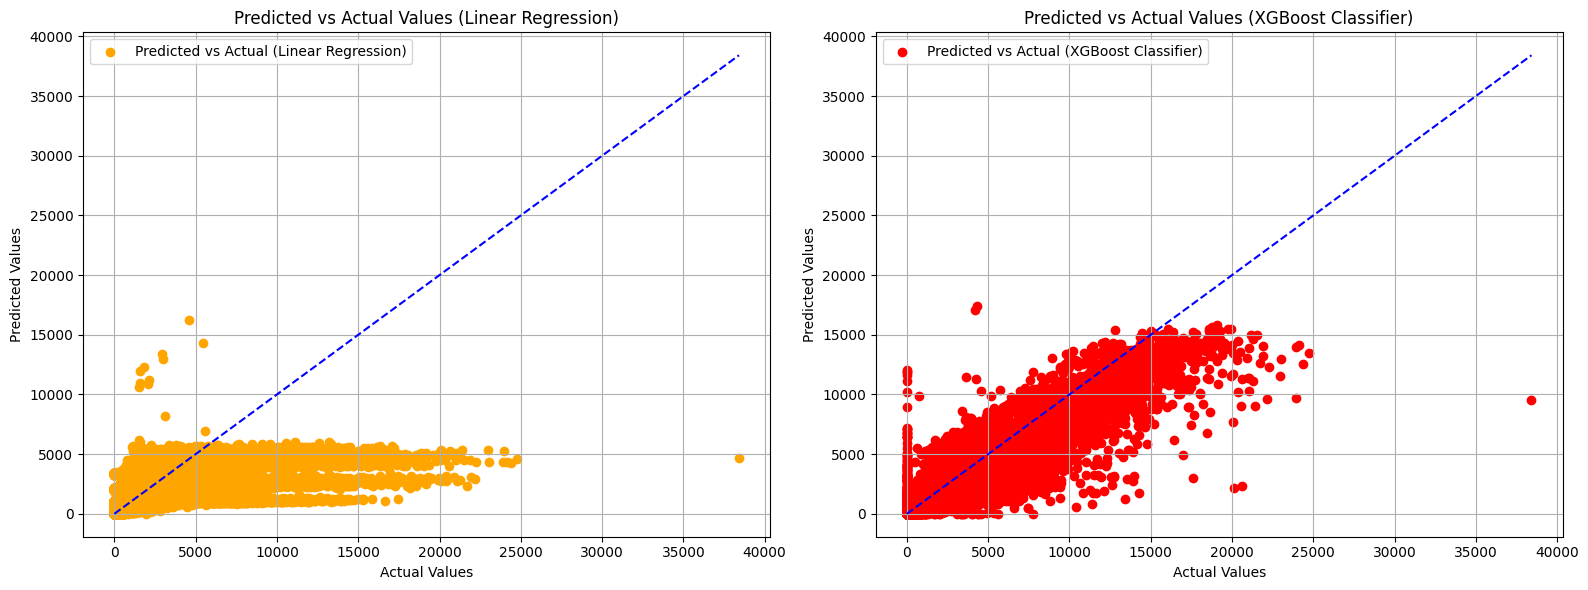

In [145]:
# Plotting Predicted values vs true 
X_test_ml.index = pd.to_datetime(X_test_ml.index)

# Create subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot for Linear Regression model
axs[0].scatter(y_test_ml, lr_predictions, color='orange', label='Predicted vs Actual (Linear Regression)')
axs[0].plot([0, np.max(y_test_ml)], [0, np.max(y_test_ml)], color='blue', linestyle='--')  # Diagonal line for reference
axs[0].set_xlabel('Actual Values')
axs[0].set_ylabel('Predicted Values')
axs[0].set_title('Predicted vs Actual Values (Linear Regression)')
axs[0].legend()
axs[0].grid(True)

# Scatter plot for XGBoost Classifier model
axs[1].scatter(y_test_ml, xgb_predictions, color='red', label='Predicted vs Actual (XGBoost Classifier)')
axs[1].plot([0, np.max(y_test_ml)], [0, np.max(y_test_ml)], color='blue', linestyle='--')  # Diagonal line for reference
axs[1].set_xlabel('Actual Values')
axs[1].set_ylabel('Predicted Values')
axs[1].set_title('Predicted vs Actual Values (XGBoost Classifier)')
axs[1].legend()
axs[1].grid(True)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

Feature Importance

In [146]:
# Get feature importance
feature_importance = model_xgb.feature_importances_

# Access column names from the preprocessor step in the pipeline
column_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

# Create a DataFrame to store feature importance
feature_importance_df = pd.DataFrame({'Feature': column_names, 'Importance': feature_importance})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df.head(55)

,Feature,Importance
18,cat__family_GROCERY I,0.416785
9,cat__family_BEVERAGES,0.162325
13,cat__family_CLEANING,0.074461
36,cat__family_PRODUCE,0.060414
14,cat__family_DAIRY,0.057601
11,cat__family_BREAD/BAKERY,0.037144
0,num__store_nbr,0.027435
34,cat__family_POULTRY,0.026200
1,num__onpromotion,0.023898
30,cat__family_MEATS,0.021333


Hyperparameter Tuning 

- Since XGB Regressor is our best performing model, we will fine-tune its hyperparameters to try and get better performance out of it.
- We will employ RandomizedGridSearch for our hyperparameter tuning.

In [147]:
# Define the parameter grid
param_dist = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.3, 0.5, 0.7],
    'gamma': [0, 0.1, 0.2],
    'alpha': [0, 0.1, 0.2],
    'lambda': [0, 0.1, 0.2]
}

# Initialize the XGBRegressor
xgb = XGBRegressor()

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    cv=3,
    random_state=0
)

# Fit RandomizedSearchCV
random_search.fit(X_train_processed, y_train_ml)

# Get the best parameters found
best_params = random_search.best_params_

# Initialize XGBRegressor with the best parameters
best_xgb_model = XGBRegressor(**best_params)

# Fit the model to the training data
best_xgb_model.fit(X_train_processed, y_train_ml)

# Print the best parameters found
print("Best parameters:", best_params)

Best parameters: {'subsample': 0.7, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 4, 'learning_rate': 0.05, 'lambda': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.3, 'alpha': 0.2}


In [148]:
# Define and train XGBoost model with the best parameters
best_xgb_model = XGBRegressor(**best_params)  # Initialize XGBoost model with best parameters
best_xgb_model.fit(X_train_processed, y_train_ml)  # Train the model

# Predict using the XGBoost model
predictions_xgb = best_xgb_model.predict(X_test_processed)
predictions_xgb_no_negative = np.maximum(predictions_xgb, 0)  # Ensure no negative values in predictions

# Compute Mean Absolute Error (MAE)
new_mae_xgb = mean_absolute_error(y_test_ml, predictions_xgb_no_negative)

# Compute Root Mean Squared Logarithmic Error (RMSLE)
new_rmsle_xgb = np.sqrt(mean_squared_error(np.log1p(y_test_ml), np.log1p(predictions_xgb_no_negative)))

# Compute Root Mean Squared Error (RMSE)
new_rmse_xgb = np.sqrt(mean_squared_error(y_test_ml, predictions_xgb_no_negative))

# Print evaluation metrics
print("XGBoost Model:")
print("Mean Absolute Error (MAE):", new_mae_xgb)
print("Root Mean Squared Logarithmic Error (RMSLE):", new_rmsle_xgb)
print("Root Mean Squared Error (RMSE):", new_rmse_xgb)

XGBoost Model:
Mean Absolute Error (MAE): 253.2234745838092
Root Mean Squared Logarithmic Error (RMSLE): 1.8314519958696245
Root Mean Squared Error (RMSE): 674.7397403669586


In [149]:
# Before and After Tuning Results

# Define performance metrics before tuning
metrics_before_tuning = {
    'Model': ['XGBoost Regressor (Before Tuning)'],
    'MAE': [xgb_mae],
    'RMSLE': [xgb_rmsle],
    'RMSE': [xgb_rmse]
}

# Define performance metrics after tuning
metrics_after_tuning = {
    'Model': ['XGBoost Regressor (After Tuning)'],
    'MAE': [new_mae_xgb],
    'RMSLE': [new_rmsle_xgb],
    'RMSE': [new_rmse_xgb]
}

# Create DataFrames
df_before_tuning = pd.DataFrame(metrics_before_tuning)
df_after_tuning = pd.DataFrame(metrics_after_tuning)

# Concatenate DataFrames for comparison
metrics_df = pd.concat([df_before_tuning, df_after_tuning], ignore_index=True)

print("Comparison Before and After Tuning for XGBoost Regressor:")
print(metrics_df)

Comparison Before and After Tuning for XGBoost Regressor:
                               Model         MAE     RMSLE        RMSE
0  XGBoost Regressor (Before Tuning)  125.965558  1.510552  404.470544
1   XGBoost Regressor (After Tuning)  253.223475  1.831452  674.739740


Notes
- The model is performing better before tuning, Hence we will drop the tuned model

**Test Data**